# Data analysis for sequence data
## data shape
- seqData : {number of objects, number of sequence, {frameIndex, label, left, top, width, height}}
- kfData : {number of objects, number of sequence, {frameIndex, xCenter,yCenter}}

## Import library

In [1]:
import csv 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import cv2
import glob
import re

## Ground truth data

### load data

In [2]:
def loadData(max_num_bbox,max_num_class,bboxFile,classFile):
    """load data from csv file

    Args:
        max_num_bbox (int): max number of bboxes
        max_num_class (int): max number of classes
        bboxFile (string):bbox file name
        classFile (string): class file name

    Returns:
        dataBbox, dataClass(list) : bbox and class data
    """
    # make column header
    unitColumn = ["frameIndex","left","top","width","height"]*max_num_bbox
    unitColumnClass = ["frameIndex","label"]*max_num_class
    col_namesBbox = [ "{i}-{name}".format(i=i,name=unitColumn[i]) for i in range(len(unitColumn)) ]
    col_namesClass = [ "{i}-{name}".format(i=i,name=unitColumnClass[i]) for i in range(len(unitColumnClass)) ]
    dfBbox = pd.read_csv(filepath_or_buffer=bboxFile,names=col_namesBbox)
    dfBbox = dfBbox.fillna(-2) # fill none in dataFrame with -1
    dfClass = pd.read_csv(filepath_or_buffer=classFile,names=col_namesClass)
    dfClass = dfClass.fillna(-2)
    dataBbox = dfBbox.values
    dataClass = dfClass.values
    dfClass[:3]
    return dataBbox, dataClass

In [3]:
#rootDir = r"C:\Users\kawaw\data_Tracking\objectTracking\yolotestmp4\4objects"
#rootDir = r"C:\Users\kawaw\cpp\objectTracking_2cams_v1\objectTracking_2cams_v1"
#switching 0109
#rootDir = r"C:\Users\kawaw\data_tracking\20240109\objectTracking\switching"
#throwing2 0109
#rootDir = r"C:\Users\kawaw\data_tracking\20240109\objectTracking\throwing2"
#throwing4 0109
#rootDir = r"C:\Users\kawaw\data_tracking\20240109\objectTracking\throwing4"
#switching2 0111
rootDir = r"C:\Users\kawaw\data_tracking\0111\switching\2"
#switching3 0111
#rootDir = r"C:\Users\kawaw\data_tracking\0111\switching\3" 
#switching4 0111
#rootDir = r"C:\Users\kawaw\data_tracking\0111\switching\4"
#throwing2 0111
#rootDir = r"C:\Users\kawaw\data_tracking\0111\throwing"
#switching_accelerate
#rootDir = r"C:\Users\kawaw\data_tracking\0112\switching\accelerate\csv\gt"
#switching_changeTrajectory
#rootDir = r"C:\Users\kawaw\data_tracking\0112\switching\changeTraj\csv\gt"
#ball&box 0119
#rootDir = r"C:\Users\kawaw\data_tracking\0119\objectTracking\ball_box\csv\gt"
#throwing2 
#rootDir = r"C:\Users\kawaw\data_tracking\0119\objectTracking\ball2_throwing\csv\gt"
#throwing3
#rootDir = r"C:\Users\kawaw\data_tracking\0119\objectTracking\ball3_throwing\csv\gt"
bboxFile_left = os.path.join(rootDir,"bbox_left_gt.csv")
bboxFile_right = os.path.join(rootDir,"bbox_right_gt.csv")
classFile_left = os.path.join(rootDir,"label_left_gt.csv")
classFile_right = os.path.join(rootDir,"label_right_gt.csv")
num_bbox_left = 100#
num_class_left = 300
num_bbox_right = 100
num_class_right = 300

bbox_gt_left,class_gt_left = loadData(max_num_bbox=num_bbox_left,max_num_class=num_class_left,bboxFile=bboxFile_left,classFile=classFile_left)
bbox_gt_right,class_gt_right = loadData(max_num_bbox=num_bbox_right,max_num_class=num_class_right,bboxFile=bboxFile_right,classFile=classFile_right)

In [4]:
print(bbox_gt_left.shape, class_gt_left.shape)

(540, 500) (540, 600)


### check wheter detection is successful

In [5]:
def checkDetection(dataClass):
    numTime = dataClass.shape[0]#time steps
    numData = dataClass.shape[1]//2#number of detection
    ret=[]
    for i in range(numTime):
        isDetected=False
        for j in range(numData):
            if dataClass[i,j*2+1]>=0:
                isDetected=True
                break
        ret.append(isDetected)
    print(ret)
    return ret

retDetection_gt_left = checkDetection(dataClass=class_gt_left) #retDetection:whether object detected
retDetection_gt_right = checkDetection(dataClass=class_gt_right) #retDetection:whether object detected

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

### convert data into dict type

In [6]:
def array2dict(dataBbox,dataClass,retDetection)-> dict:
    """convert np.array to dict

    Args:
        dataBbox (np.array): sequence data of each detections
        dataClass (np.array): class label transition. if label chnage from 0 or 1 to -1, lost
        retDetection (np.array): [True or False, ,,,, ] if detected -> True

    Returns:
        data(dict): {"ball-1":[[frameIndex,left,top,width,height],,,],"box-1":,,,}
    """
    #copy data
    dataBboxCopy = dataBbox.copy()
    dataClassCopy = dataClass.copy()
    numBbox = dataBbox.shape[1]//5 #number of detections
    classLabel = []
    counterBall = 1
    counterBox = 1
    data = dict()
    numTime = dataClass.shape[0] #number of time steps
    numData = dataClass.shape[1]//2 #number of total detections
    for i in range(numData): #num of data
        counterDetection=0
        #print(f"{i}-th objects")
        tempClassData = dataClassCopy[:,i*2:(i+1)*2] #get data of [frameIndex, classLabel]
        #tempBboxData = dataBboxCopy[:,]
        boolStart=False #start signal
        boolBall = False #ball detection
        boolBox = False #box detection
        bboxes=[]
        for j in range(numTime): #number of sequence
            #print(f"{j}-th time-step :: {tempClassData[j,1]} :: {counterDetection}")
            #print(f"counterDetection :: {counterDetection}")
            #print(f"isBall:{boolBall},isBox:{boolBox}")
            numObjects=0 #number of detected objects
            if (tempClassData[j,1]>=0): #detection data is available
                boolStart=True
                Ball = int(tempClassData[j,1])==0
                Box = int(tempClassData[j,1])==1
                if Ball:
                    print("Ball")
                    # move to available data
                    while(dataBboxCopy[counterDetection,numObjects*5] < 0):
                        numObjects += 1
                    #print(f"numberObjects : {numObjects}")
                    bboxes.append(dataBboxCopy[counterDetection,numObjects*5:(numObjects+1)*5].tolist())
                    boolBall=True #ball detected
                    # change data to -1,-1,-1,-1,-1
                    for k in range(5):
                        dataBboxCopy[counterDetection,numObjects*5+k] =-1
                elif Box:
                    print("Box")
                    # move to available data
                    while(dataBboxCopy[counterDetection,numObjects*5] < 0):
                        numObjects += 1
                    #print(f"numberObjects : {numObjects}")
                    bboxes.append(dataBboxCopy[counterDetection,numObjects*5:(numObjects+1)*5].tolist())
                    boolBox=True
                    # change data to -1,-1,-1,-1,-1
                    for k in range(5):
                        dataBboxCopy[counterDetection,numObjects*5+k] =-1
            else: #detection data is not available
                if boolStart: #already started
                    break
            #if increment counter of bbox
            if retDetection[j]:
                counterDetection+=1
        print(f"isBall:{boolBall},isBox:{boolBox}")
        if boolBall: #ball detection
            data[f"Ball-{counterBall}"] = bboxes
            counterBall+=1
        elif boolBox: #box detection
            data[f"Box-{counterBox}"] = bboxes
            counterBox+=1
    return data

In [7]:
dict_gt_left = array2dict(dataBbox=bbox_gt_left,dataClass=class_gt_left,retDetection=retDetection_gt_left)
dict_gt_right = array2dict(dataBbox=bbox_gt_right,dataClass=class_gt_right,retDetection=retDetection_gt_right)

Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball
Ball


### plot ground truth data

In [8]:
markers=['o','s','D','+','x','^','v','>','<','p','H','8']
lines = [" ","--"]
colors=["r","g","b","c","m","y","k","w"]
'''
'o': Circle
's': Square
'D': Diamond
'+': Plus sign
'x': X
'^': Upward-pointing triangle
'v': Downward-pointing triangle
'>': Right-pointing triangle
'<': Left-pointing triangle
'p': Pentagram (five-pointed star)
'H': Hexagon
'8': Octagon
'''

"\n'o': Circle\n's': Square\n'D': Diamond\n'+': Plus sign\n'x': X\n'^': Upward-pointing triangle\n'v': Downward-pointing triangle\n'>': Right-pointing triangle\n'<': Left-pointing triangle\n'p': Pentagram (five-pointed star)\n'H': Hexagon\n'8': Octagon\n"

In [9]:
#Ground Truth
def plotData(data,color,data_name,pos,fig,ax):
    numBall=0
    numBox=0
    for key in data:
        label = key.split("-")[0] #label : ball or box
        tempData = data[key]
        tempFrame = []
        tempPositionX = []
        tempPositionY = []
        for i in range(len(tempData)):
            tempFrame.append(tempData[i][0])
            centerX = tempData[i][1]+tempData[i][3]/2
            centerY = tempData[i][2]+tempData[i][4]/2
            tempPositionX.append(centerX)
            tempPositionY.append(centerY)
        if pos == "left":
            if data_name == "rawData":
                if (label=="Ball"):
                    ax[0][0].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBall%len(markers)]) #colors[numBall//len(colors)]
                    ax[1][0].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBall%len(markers)])
                    numBall += 1
                elif (label=="Box"):
                    ax[0][1].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBox%len(markers)])
                    ax[1][1].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBox%len(markers)])
                    numBox += 1
            else:    
                if (label=="Ball"):
                    ax[0][0].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBall%len(markers)],label=key+"-"+data_name) #colors[numBall//len(colors)]
                    ax[1][0].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBall%len(markers)])
                    numBall += 1
                elif (label=="Box"):
                    ax[0][1].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBox%len(markers)],label=key+"-"+data_name)
                    ax[1][1].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBox%len(markers)])
                    numBox += 1
        elif pos == "right":
            if data_name == "rawData":
                if (label=="Ball"):
                    ax[2][0].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBall%len(markers)]) #colors[numBall//len(colors)]
                    ax[3][0].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBall%len(markers)])
                    numBall += 1
                elif (label=="Box"):
                    ax[2][1].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBox%len(markers)])
                    ax[3][1].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBox%len(markers)])
                    numBox += 1

            else:
                if (label=="Ball"):
                    ax[2][0].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBall%len(markers)],label=key+"-"+data_name) #colors[numBall//len(colors)]
                    ax[3][0].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBall%len(markers)])
                    numBall += 1
                elif (label=="Box"):
                    ax[2][1].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBox%len(markers)],label=key+"-"+data_name)
                    ax[3][1].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBox%len(markers)])
                    numBox += 1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


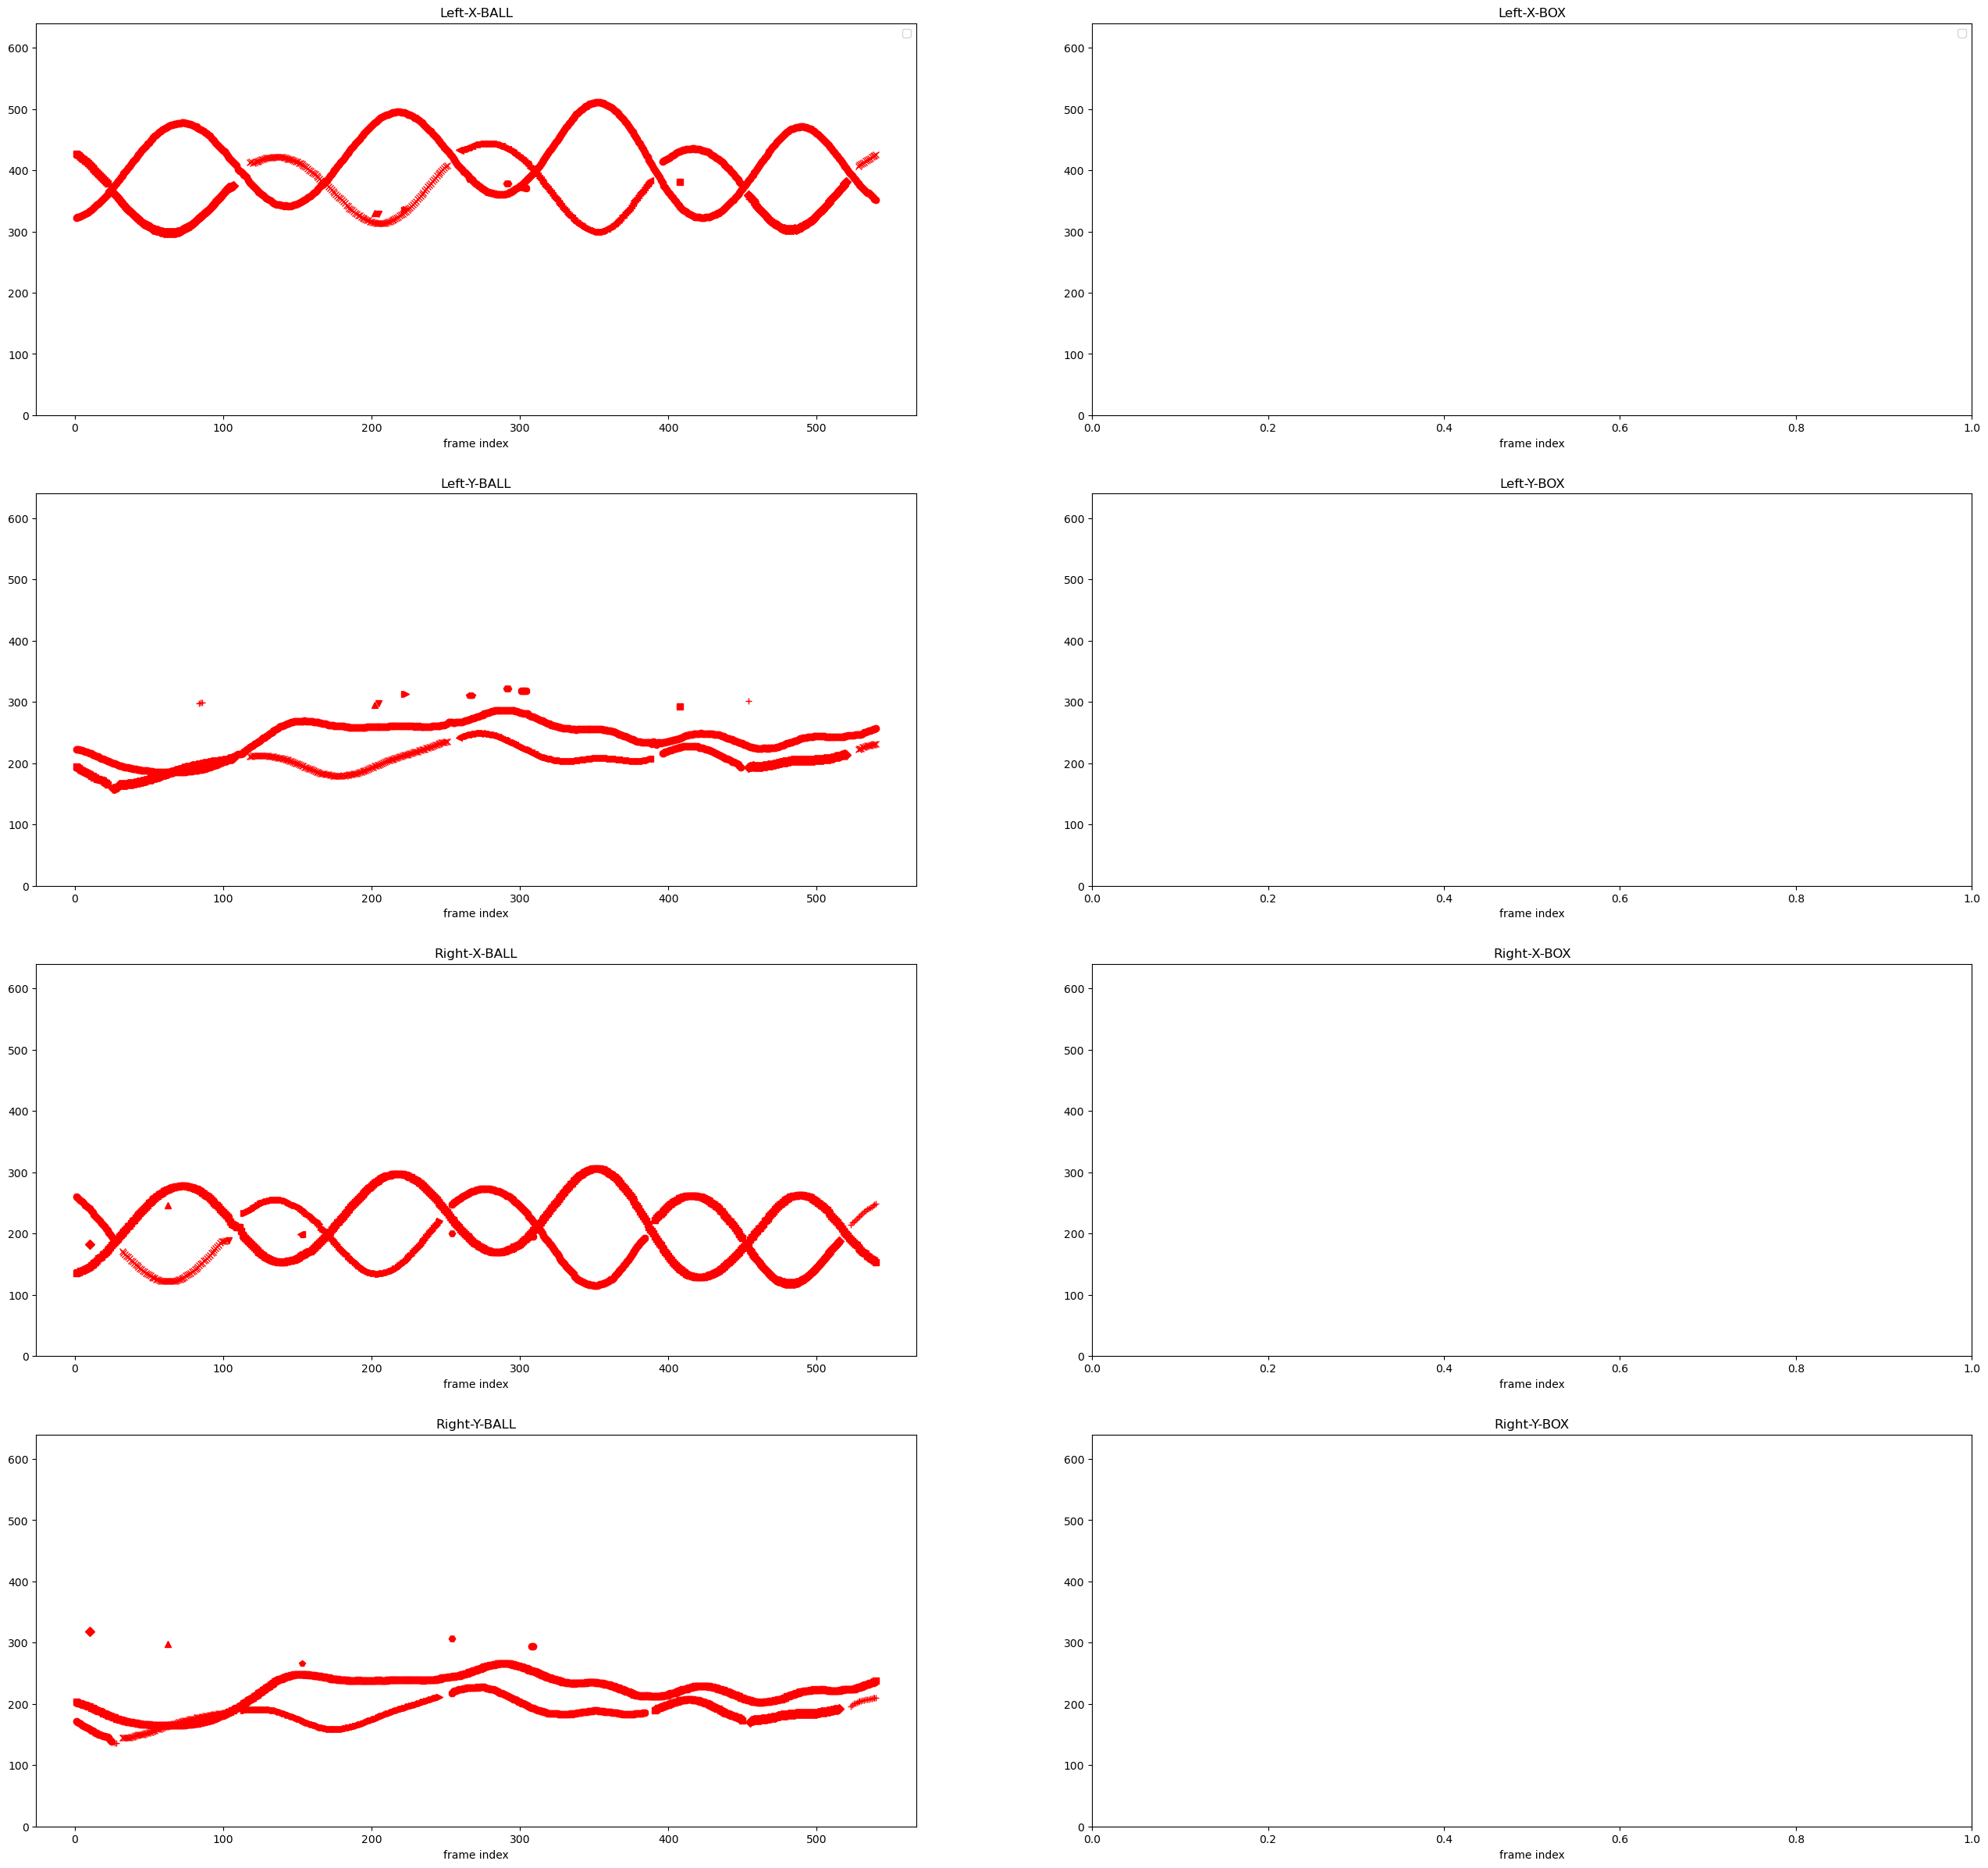

In [10]:
poss = ["Left","Right"]
types = ["BALL","BOX"]
axes = ["X","Y"]
titles = []
for pos in poss:
    for axis in axes:
        for type in types:
            titles.append(pos+"-"+axis+"-"+type)
fig,ax = plt.subplots(4,2,figsize=(32,30))
plotData(data=dict_gt_left,color="r",data_name="rawData",pos="left",fig=fig,ax=ax)
plotData(data=dict_gt_right,color="r",data_name="rawData",pos="right",fig=fig,ax=ax)
for i in range(4): #y
    for j in range(2): #x
        if i== 0:
            ax[i][j].legend()
        ax[i][j].set_ylim(0,640)
        ax[i][j].set_title(titles[i*2+j])
        ax[i][j].set_xlabel("frame index")
plt.show()

## Load data and convert into dict type 
- {num of objects, num of sequence, {frameIndex, label,left,top,width,height}}
    -> 
- dict_frames (dict) : {1: [1,2,3,,,], 2:[3,4,5,,,],,,} :: {num of objects, [frames]}
- dict_seqData (dict) : {1: [[2,2],[2,4],,,], 2:[[3,3],,],,} :: {num of objects, [[xCenter,yCenter]]}

In [11]:
def loadSeqData(max_num,file):
    """load data from csv file

    Args:
        max_num (int): max number of data
        file (string):file name

    Returns:
        dataBbox, : {number of obejects, number of sequence, {frameIndex, label, left, top, width, height}}
    """
    # make column header
    unitColumn = ["frameIndex","label","left","top","width","height"]*max_num
    col_namesBbox = [ "{i}-{name}".format(i=i,name=unitColumn[i]) for i in range(len(unitColumn)) ]
    dfBbox = pd.read_csv(filepath_or_buffer=file,names=col_namesBbox)
    dfBbox = dfBbox.fillna(-2) # fill none in dataFrame with -1
    dataBbox = dfBbox.values
    print("data shape : ",dataBbox.shape)
    return dataBbox

def loadKfData(max_num,file):
    """load data from csv file

    Args:
        max_num (int): max number of data
        file (string):file name

    Returns:
        dataBbox, : {number of obejects, number of sequence, {frameIndex, xCenter,yCenter}}
    """
    # make column header
    unitColumn = ["frameIndex","xCenter","yCenter"]*max_num
    col_namesBbox = [ "{i}-{name}".format(i=i,name=unitColumn[i]) for i in range(len(unitColumn)) ]
    dfBbox = pd.read_csv(filepath_or_buffer=file,names=col_namesBbox)
    dfBbox = dfBbox.fillna(-2) # fill none in dataFrame with -1
    dataBbox = dfBbox.values
    print("data shape : ",dataBbox.shape)
    return dataBbox

### Yolo & Kalmanfilter

In [12]:
#rootDir = r"C:\Users\kawaw\cpp\objectTracking_yolo_kalmanfilter\objectTracking_yolo_kalmanfilter"
#rootDir = r"C:\Users\kawaw\data_tracking\0112\switching\accelerate\csv\kf"
#rootDir = r"C:\Users\kawaw\data_tracking\0112\switching\changeTraj\csv\kf"
#rootDir = r"C:\Users\kawaw\data_tracking\0119\objectTracking\ball_box\csv\kf"
#rootDir = r"C:\Users\kawaw\data_tracking\0119\objectTracking\ball3_throwing\csv\kf"
#rootDir = r"C:\Users\kawaw\data_tracking\0119\objectTracking\ball2_throwing\csv\kf"
#switching3
rootDir = r"C:\Users\kawaw\data_tracking\0111\switching\4\result\kf"
file_seq_ball_left = os.path.join(rootDir,"seqData_ball_left.csv")
file_seq_box_left = os.path.join(rootDir,"seqData_box_left.csv")
file_seq_ball_right = os.path.join(rootDir,"seqData_ball_right.csv")
file_seq_box_right = os.path.join(rootDir,"seqData_box_right.csv")
file_kf_ball_left = os.path.join(rootDir,"kfData_ball_left.csv")
file_kf_box_left = os.path.join(rootDir,"kfData_box_left.csv")
file_kf_ball_right = os.path.join(rootDir,"kfData_ball_right.csv")
file_kf_box_right = os.path.join(rootDir,"kfData_box_right.csv")

max_num = 300
seqData_ball_left = loadSeqData(max_num=max_num,file=file_seq_ball_left)
seqData_box_left = loadSeqData(max_num=max_num,file=file_seq_box_left)
seqData_ball_right = loadSeqData(max_num=max_num,file=file_seq_ball_right)
seqData_box_right = loadSeqData(max_num=max_num,file=file_seq_box_right)
kfData_ball_left = loadKfData(max_num=max_num,file=file_kf_ball_left)
kfData_box_left = loadKfData(max_num=max_num,file=file_kf_box_left)
kfData_ball_right = loadKfData(max_num=max_num,file=file_kf_ball_right)
kfData_box_right = loadKfData(max_num=max_num,file=file_kf_box_right)

data shape :  (19, 1800)
data shape :  (0, 1800)
data shape :  (21, 1800)
data shape :  (0, 1800)
data shape :  (19, 900)
data shape :  (0, 900)
data shape :  (21, 900)
data shape :  (0, 900)


### Yolo&MOSSE&Kf

In [14]:
#switching_accelerate
#rootDir = r"C:\Users\kawaw\data_tracking\0112\switching\accelerate\csv\realtime"
rootDir=r"C:\Users\kawaw\cpp\objectTracking_2cams_mosse_templatematching_kf\objectTracking_2cams_mosse_templatematching_kf"
#rootDir=r"C:\Users\kawaw\cpp\objectTracking_latest\objectTracking_latest"
#switching_changeTrajectory
#rootDir = r"C:\Users\kawaw\data_tracking\0112\switching\changeTraj\csv\realtime"
#ball&box 0119
#rootDir = r"C:\Users\kawaw\data_tracking\0119\objectTracking\ball_box\csv\realtime"
#throwing2 
#rootDir = r"C:\Users\kawaw\data_tracking\0119\objectTracking\ball2_throwing\csv\realtime"
#throwing3
#rootDir = r"C:\Users\kawaw\data_tracking\0119\objectTracking\ball3_throwing\csv\realtime"
#switching3
#rootDir = r"C:\Users\kawaw\data_tracking\0111\switching\2\result\MOSSE_TM_KF_PSRCHECK_DUPLICATED"#\MOSSE_TM_KF_PSRCHECK_DUPLICATED_DYNAMICSEARCH_SKIP"
#rootDir = r"C:\Users\kawaw\data_tracking\0111\switching\4\result\proposed"#\MOSSE_TM_KF_PSRCHECK_DUPLICATED_DYNAMICSEARCH_SKIP"

#max objects
max_num = 3000

#TM+MOSSE_KF
tmossekfDir = os.path.join(rootDir)
tmossekf_file_seq_left = os.path.join(tmossekfDir,"seqData_left.csv")
tmossekf_file_seq_right = os.path.join(tmossekfDir,"seqData_right.csv")
tmossekf_file_kf_left = os.path.join(tmossekfDir,"kfData_left.csv")
tmossekf_file_kf_right = os.path.join(tmossekfDir,"kfData_right.csv")
tmossekf_seqData_left = loadSeqData(max_num=max_num,file=tmossekf_file_seq_left)
tmossekf_seqData_right = loadSeqData(max_num=max_num,file=tmossekf_file_seq_right)
tmossekf_kfData_left = loadKfData(max_num=max_num,file=tmossekf_file_kf_left)
tmossekf_kfData_right = loadKfData(max_num=max_num,file=tmossekf_file_kf_right)

data shape :  (8, 18000)
data shape :  (12, 18000)
data shape :  (8, 9000)
data shape :  (12, 9000)


### Yolo&KF

In [15]:
def seq2Seq(data,min_duration):
    """from sequential data to frameIndex and xCenter data

    Args:
        data (list):  {frameIndex, label, left, top, width, height}*(num detected frames)

    Return:
        dict_frames (dict) : {1: [1,2,3,,,], 2:[3,4,5,,,],,,} :: {num of objects, [frames]}
        dict_seqData (dict) : {1: [[2,2],[2,4],,,], 2:[[3,3],,],,} :: {num of objects, [[xCenter,yCenter]]}
    """
    counter = 0
    dict_frames = dict()
    dict_seqData = dict()
    for i in range(data.shape[0]): #for each objects
        counter = 1
        frames = []
        seqData = []
        #print(data.shape[1])
        while (data[i][(counter)*6] != -2 and counter*6<data.shape[1]):
            #print(frames)
            #print(counter*6)
            #if (len(frames)>0):
            #    if (frames[-1]>=300):
            #        break
            if (len(seqData)>0):
                while (frames[-1]<data[i][(counter)*6]-1): #compensate data
                    frames.append(frames[-1]+1)
                    seqData.append([seqData[-1][0],seqData[-1][1]])
            if (data[i][(counter)*6]>0):
                frames.append(data[i][counter*6])
                seqData.append([(data[i][(counter-1)*6+2]+data[i][(counter-1)*6+4]/2),(data[i][(counter-1)*6+3]+data[i][(counter-1)*6+5]/2)]) #[xCenter,yCenter]
            else: #failed
                if (len(seqData)>0):
                    frames.append(frames[-1]+1)
                    seqData.append([seqData[-1][0],seqData[-1][1]])
            counter+=1
            if (counter*6>=data.shape[1]):
                break
        if (len(seqData)>=min_duration):
            print(frames)
            dict_frames[i+1] = np.array(frames)
            dict_seqData[i+1] = np.array(seqData)
    return dict_frames, dict_seqData

def kf2Seq(data,min_duration):
    """from sequential data to frameIndex and xCenter data

    Args:
        data (list):  {frameIndex, xCenter,yCenter}*(num detected frames)

    Return:
        dict_frames (dict) : {1: [1,2,3,,,], 2:[3,4,5,,,],,,} :: {num of objects, [frames]}
        dict_seqData (dict) : {1: [[2,2],[2,4],,,], 2:[[3,3],,],,} :: {num of objects, [[xCenter,yCenter]]}
    """
    counter = 0
    dict_frames = dict()
    dict_seqData = dict()
    for i in range(data.shape[0]): #for each objects
        counter = 1
        frames = []
        seqData = []
        while (data[i][counter*3] >0):
            if (len(frames)>0):
                if (frames[-1]<=300):
                    break
            if (len(seqData)>0):
                while (frames[-1]<data[i][counter*3]-1): #compensate data
                        frames.append(frames[-1]+1)
                        seqData.append([seqData[-1][0],seqData[-1][1]])
            if (data[i][(counter)*3+1]>0):
                frames.append(data[i][counter*3])
                seqData.append([data[i][(counter-1)*3+1],data[i][(counter-1)*3+2]]) #[xCenter,yCenter]
            else: #failed
                frames.append(frames[-1]+1)
                seqData.append([seqData[-1][0],seqData[-1][1]])
            counter+=1
            if (counter*3>=data.shape[1]):
                break
        if (len(seqData)>=min_duration):
            dict_frames[i+1] = np.array(frames)
            dict_seqData[i+1] = np.array(seqData)
    return dict_frames, dict_seqData

In [16]:
MIN_DURATION=5
#sequential data
dict_base_seq_frame_ball_left,dict_base_seq_ball_left = seq2Seq(data=seqData_ball_left,min_duration=MIN_DURATION)
dict_base_seq_frame_box_left,dict_base_seq_box_left = seq2Seq(data=seqData_box_left,min_duration=MIN_DURATION)
dict_base_seq_frame_ball_right,dict_base_seq_ball_right = seq2Seq(data=seqData_ball_right,min_duration=MIN_DURATION)
dict_base_seq_frame_box_right,dict_base_seq_box_right = seq2Seq(data=seqData_box_right,min_duration=MIN_DURATION)
#kalman prediction data
dict_base_kf_frame_ball_left,dict_base_kf_ball_left = seq2Seq(data=seqData_ball_left,min_duration=MIN_DURATION)
dict_base_kf_frame_box_left,dict_base_kf_box_left = seq2Seq(data=seqData_box_left,min_duration=MIN_DURATION)
dict_base_kf_frame_ball_right,dict_base_kf_ball_right = seq2Seq(data=seqData_ball_right,min_duration=MIN_DURATION)
dict_base_kf_frame_box_right,dict_base_kf_box_right = seq2Seq(data=seqData_box_right,min_duration=MIN_DURATION)

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0]
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 12

### YOLO&MOSSE&KF

In [17]:
def seq2Seq(data,min_duration):
    """from sequential data to frameIndex and xCenter data

    Args:
        data (list):  {frameIndex, label, left, top, width, height}*(num detected frames)

    Return:
        dict_frames_ball, dict_frames_box (dict) : {1: [1,2,3,,,], 2:[3,4,5,,,],,,} :: {num of objects, [frames]}
        dict_seqData_ball, dice_seqData_box (dict) : {1: [[2,2],[2,4],,,], 2:[[3,3],,],,} :: {num of objects, [[xCenter,yCenter]]}
    """
    counter = 0
    num_ball = 0
    num_box = 0
    dict_frames_ball = dict()
    dict_seqData_ball = dict()
    dict_frames_box = dict()
    dict_seqData_box = dict()
    for i in range(data.shape[0]): #for each objects
        counter = 1
        frames = []
        seqData = []
        #print(data.shape[1])
        while (data[i][counter*6] != -2):
            #if (len(frames)>0):
            #    if (frames[-1]>=300):
            #        break
            #print(counter*6)
            if (len(seqData)>0):
                while (frames[-1]<data[i][counter*6]-1): #compensate data
                    frames.append(frames[-1]+1)
                    seqData.append([seqData[-1][0],seqData[-1][1]])
            if (data[i][counter*6]>0): #detected
                frames.append(data[i][counter*6])
                seqData.append([(data[i][(counter-1)*6+2]+data[i][(counter-1)*6+4]/2),(data[i][(counter-1)*6+3]+data[i][(counter-1)*6+5]/2)]) #[xCenter,yCenter]
            else: #failed
                if (len(seqData)>0):
                    frames.append(frames[-1]+1)
                    seqData.append([seqData[-1][0],seqData[-1][1]])
            counter+=1
            #terminal condition
            if (counter*6>=data.shape[1]):
                break
        if (data[i][1] == 0 and len(seqData)>=min_duration): #ball
            num_ball += 1
            dict_frames_ball[num_ball] = np.array(frames)
            dict_seqData_ball[num_ball] = np.array(seqData)
            print(np.array(frames).shape,np.array(seqData).shape)
        elif (data[i][1] == 1 and len(seqData)>=min_duration): #box
            num_ball += 1
            dict_frames_box[num_ball] = np.array(frames)
            dict_seqData_box[num_ball] = np.array(seqData)
            print(np.array(frames).shape,np.array(seqData).shape)
    return dict_frames_ball, dict_seqData_ball,dict_frames_box, dict_seqData_box

In [18]:
MIN_DURATION = 5#minimuum length of tracker
#sequential data
#TM+MOSSE+KF
tmossekf_dict_seq_frame_ball_left,tmossekf_dict_seqData_ball_left,tmossekf_dict_seq_frame_box_left,tmossekf_dict_seqData_box_left = seq2Seq(data=tmossekf_seqData_left,min_duration=MIN_DURATION)
tmossekf_dict_seq_frame_ball_right,tmossekf_dict_seqData_ball_right,tmossekf_dict_seq_frame_box_right,tmossekf_dict_seqData_box_right = seq2Seq(data=tmossekf_seqData_right,min_duration=MIN_DURATION)
#kalman prediction data
tmossekf_dict_kf_frame_ball_left,tmossekf_dict_kfData_ball_left,tmossekf_dict_kf_frame_box_left,tmossekf_dict_kfData_box_left = seq2Seq(data=tmossekf_kfData_left,min_duration=MIN_DURATION)
tmossekf_dict_kf_frame_ball_right,tmossekf_dict_kfData_ball_right,tmossekf_dict_kf_frame_box_right,tmossekf_dict_kfData_box_right = seq2Seq(data=tmossekf_kfData_right,min_duration=MIN_DURATION)

(530,) (530, 2)
(530,) (530, 2)
(398,) (398, 2)
(150,) (150, 2)
(221,) (221, 2)
(9,) (9, 2)
(20,) (20, 2)
(531,) (531, 2)
(531,) (531, 2)
(347,) (347, 2)
(306,) (306, 2)
(46,) (46, 2)
(52,) (52, 2)
(22,) (22, 2)
(17,) (17, 2)
(530,) (530, 2)
(530,) (530, 2)
(398,) (398, 2)
(150,) (150, 2)
(221,) (221, 2)
(31,) (31, 2)
(20,) (20, 2)
(531,) (531, 2)
(531,) (531, 2)
(347,) (347, 2)
(306,) (306, 2)
(46,) (46, 2)
(78,) (78, 2)
(61,) (61, 2)
(17,) (17, 2)
(17,) (17, 2)


## plot all data 

In [19]:
markers=['o','s','D','+','x','^','v','>','<','p','H','8']
lines = [" ","--"]
colors=["r","g","b","c","m","y","k","w"]
'''
'o': Circle
's': Square
'D': Diamond
'+': Plus sign
'x': X
'^': Upward-pointing triangle
'v': Downward-pointing triangle
'>': Right-pointing triangle
'<': Left-pointing triangle
'p': Pentagram (five-pointed star)
'H': Hexagon
'8': Octagon
'''

"\n'o': Circle\n's': Square\n'D': Diamond\n'+': Plus sign\n'x': X\n'^': Upward-pointing triangle\n'v': Downward-pointing triangle\n'>': Right-pointing triangle\n'<': Left-pointing triangle\n'p': Pentagram (five-pointed star)\n'H': Hexagon\n'8': Octagon\n"

In [20]:
def plotData(dict_seq_frame_ball_left,dict_seq_frame_ball_right,dict_seq_frame_box_left,dict_seq_frame_box_right,
             dict_seq_ball_left, dict_seq_ball_right,dict_seq_box_left,dict_seq_box_right,
             colors_ball,colors_box,marker_ball,marker_box,track_type,alpha,fig,ax,):
    """_summary_

    Args:
        dict_seq_frame_ball_left (_type_): frame :: {1(detection index):[1,2,3,,,],2:[1,2,3,,],,,}
        dict_seq_frame_ball_right (_type_): 
        dict_seq_frame_box_left (_type_): 
        dict_seq_frame_box_right (_type_):
        dict_seq_ball_left (_type_): sequential data {1:{[[xCenter,yCenter],,],2:[,,,]}}
        dict_seq_ball_right (_type_): 
        dict_seq_box_left (_type_): 
        dict_seq_box_right (_type_): 
        color_ball (char): plot color for ball
        color_box (char): plot color for box
        track_type : "ground truth", "real time", "kalman prediction"
        fig (_type_): _description_
        ax (_type_): _description_
    """
    counter = 0
    #left
    for key in dict_seq_frame_ball_left: #ball left
        #print(dict_seq_frame_ball_left[key].shape,dict_seq_ball_left[key][:,0].shape)
        if counter == 0:
            ax[0,0].plot(dict_seq_frame_ball_left[key],dict_seq_ball_left[key][:,0],color=colors_ball[counter%len(colors_ball)],linestyle=" ",marker=marker_ball,label="ball-"+track_type,alpha=alpha) #x
        else:
            if (dict_seq_frame_ball_left[key].shape[0] == dict_seq_ball_left[key][:,0].shape[0]):
                ax[0,0].plot(dict_seq_frame_ball_left[key],dict_seq_ball_left[key][:,0],color=colors_ball[counter%len(colors_ball)],linestyle=" ",marker=marker_ball,alpha=alpha)
        if (dict_seq_frame_ball_left[key].shape[0] == dict_seq_ball_left[key][:,1].shape[0]):
            ax[0,1].plot(dict_seq_frame_ball_left[key],dict_seq_ball_left[key][:,1],color=colors_ball[counter%len(colors_ball)],linestyle=" ",marker=marker_ball,alpha=alpha)
        counter += 1
    counter = 0
    for key in dict_seq_frame_box_left: #box left
        #print(dict_seq_frame_ball_left[key].shape,dict_seq_ball_left[key][:,0].shape)
        if counter == 0:
            ax[0,0].plot(dict_seq_frame_box_left[key],dict_seq_box_left[key][:,0],color=colors_box[(counter%len(colors_box))],linestyle=" ",marker=marker_box,label="box-"+track_type,alpha=alpha)
        else:
            if (dict_seq_frame_box_left[key].shape[0] == dict_seq_box_left[key][:,0].shape[0]):
                ax[0,0].plot(dict_seq_frame_box_left[key],dict_seq_box_left[key][:,0],color=colors_box[(counter%len(colors_box))],linestyle=" ",marker=marker_box,alpha=alpha)
        if (dict_seq_frame_box_left[key].shape[0] == dict_seq_box_left[key][:,1].shape[0]):     
            ax[0,1].plot(dict_seq_frame_box_left[key],dict_seq_box_left[key][:,1],color=colors_box[(counter%len(colors_box))],linestyle=" ",marker=marker_box,alpha=alpha)
        counter += 1    
    #right
    counter = 0
    for key in dict_seq_frame_ball_right: #ball right
        #print(dict_seq_frame_ball_left[key].shape,dict_seq_ball_left[key][:,0].shape)
        if counter == 0:
            ax[1,0].plot(dict_seq_frame_ball_right[key],dict_seq_ball_right[key][:,0],color=colors_ball[counter%len(colors_ball)],linestyle=" ",marker=marker_ball,label="ball-"+track_type,alpha=alpha) #x
        else:
            if (dict_seq_frame_ball_right[key].shape[0] == dict_seq_ball_right[key][:,0].shape[0]):
                ax[1,0].plot(dict_seq_frame_ball_right[key],dict_seq_ball_right[key][:,0],color=colors_ball[counter%len(colors_ball)],linestyle=" ",marker=marker_ball,alpha=alpha)
        if (dict_seq_frame_ball_right[key].shape[0] == dict_seq_ball_right[key][:,1].shape[0]):
            ax[1,1].plot(dict_seq_frame_ball_right[key],dict_seq_ball_right[key][:,1],color=colors_ball[counter%len(colors_ball)],linestyle=" ",marker=marker_ball,alpha=alpha)
        counter += 1
    counter = 0
    for key in dict_seq_frame_box_right: #box left
        #print(dict_seq_frame_ball_left[key].shape,dict_seq_ball_left[key][:,0].shape)
        if counter == 0:
            ax[1,0].plot(dict_seq_frame_box_right[key],dict_seq_box_right[key][:,0],color=colors_box[(counter%len(colors_box))],linestyle=" ",marker=marker_box,label="box-"+track_type,alpha=alpha)
        else:
            if (dict_seq_frame_box_right[key].shape[0] == dict_seq_box_right[key][:,0].shape[0]):
                ax[1,0].plot(dict_seq_frame_box_right[key],dict_seq_box_right[key][:,0],color=colors_box[(counter%len(colors_box))],linestyle=" ",marker=marker_box,alpha=alpha)
        if (dict_seq_frame_box_right[key].shape[0] == dict_seq_box_right[key][:,1].shape[0]):
            ax[1,1].plot(dict_seq_frame_box_right[key],dict_seq_box_right[key][:,1],color=colors_box[(counter%len(colors_box))],linestyle=" ",marker=marker_box,alpha=alpha)
        counter += 1

### Yolo & KF

C:\Users\kawaw\AppData\Local\Temp\ipykernel_23824\1192536590.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


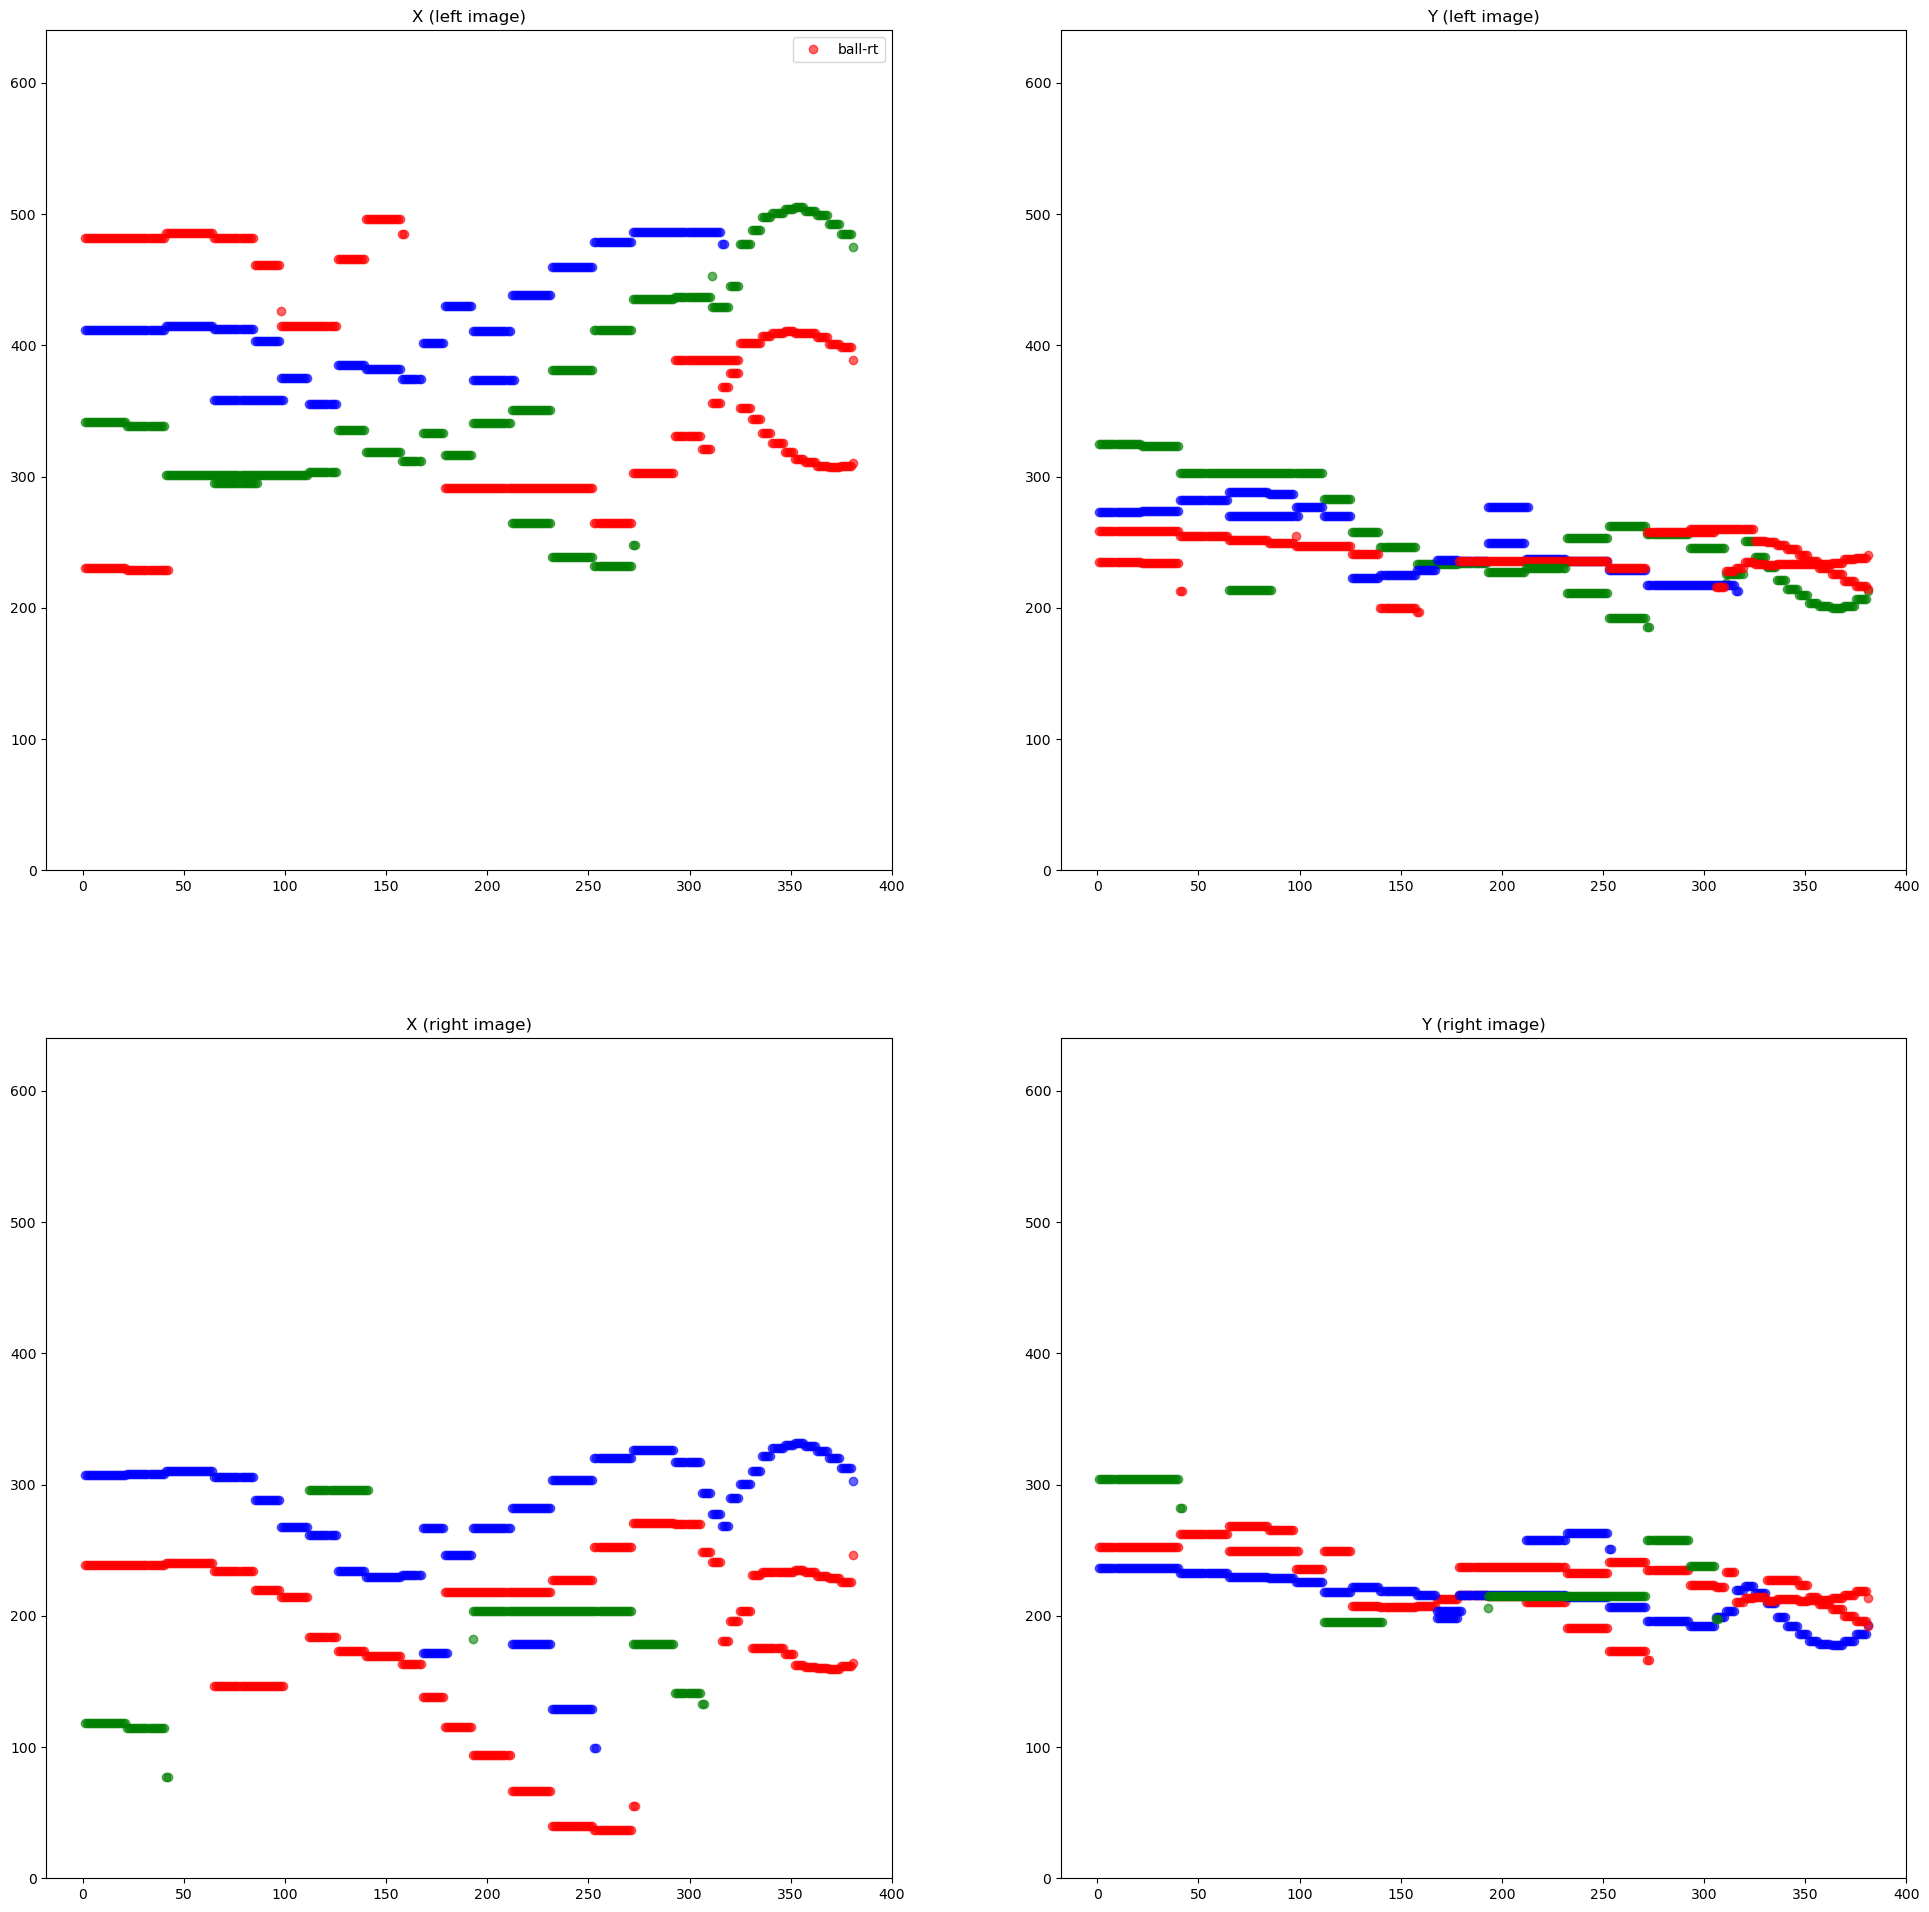

In [21]:
colors_ball = ["r","g","b"]
colors_box = ["c","y"]
color_ball_kf = ["g","g"]
color_box_kf = ["y","y"]
marker_ball = "o"
marker_box = "D"
rt_data = "rt" #real-time data
kf_data = "kf" #kalman prediction data
ALPHA = 0.6
fig,ax = plt.subplots(2,2,figsize=(24,24))
plotData(dict_seq_frame_ball_left=dict_base_seq_frame_ball_left,dict_seq_frame_ball_right=dict_base_seq_frame_ball_right,dict_seq_frame_box_left=dict_base_seq_frame_box_left,dict_seq_frame_box_right=dict_base_seq_frame_box_right,
             dict_seq_ball_left=dict_base_seq_ball_left, dict_seq_ball_right=dict_base_seq_ball_right,dict_seq_box_left=dict_base_seq_box_left,dict_seq_box_right=dict_base_seq_box_right,
             colors_ball=colors_ball,colors_box=colors_box,marker_ball=marker_ball,marker_box=marker_box,track_type=rt_data,alpha=ALPHA,fig=fig,ax=ax)
#plotData(dict_seq_frame_ball_left=dict_base_kf_frame_ball_left,dict_seq_frame_ball_right=dict_base_kf_frame_ball_right,dict_seq_frame_box_left=dict_base_kf_frame_box_left,dict_seq_frame_box_right=dict_base_kf_frame_box_right,
#             dict_seq_ball_left=dict_base_kf_ball_left, dict_seq_ball_right=dict_base_kf_ball_right,dict_seq_box_left=dict_base_kf_box_left,dict_seq_box_right=dict_base_kf_box_right,
#             colors_ball=colors_ball,colors_box=colors_box,marker_ball=marker_ball,marker_box=marker_box,track_type=kf_data,alpha=0.5,fig=fig,ax=ax)
ax[0,0].set_title("X (left image)")
ax[0,1].set_title("Y (left image)")
ax[1,0].set_title("X (right image)")
ax[1,1].set_title("Y (right image)")
ax[0,0].set_ylim(0,640)
ax[0,1].set_ylim(0,640)
ax[1,0].set_ylim(0,640)
ax[1,1].set_ylim(0,640)
ax[0,0].legend()
fig.show()

## Plot both ground truth and realtime data

In [22]:
#Ground Truth
def plotDataGT(data,color,data_name,pos,fps,fig,ax):
    numBall=0
    numBox=0
    for key in data:
        label = key.split("-")[0] #label : ball or box
        tempData = data[key]
        tempFrame = []
        tempPositionX = []
        tempPositionY = []
        for i in range(len(tempData)):
            tempFrame.append(round(tempData[i][0],1))
            centerX = tempData[i][1]+tempData[i][3]/2
            centerY = tempData[i][2]+tempData[i][4]/2
            tempPositionX.append(centerX)
            tempPositionY.append(centerY)
        if pos == "left":
            if data_name == "rawData":
                if (label=="Ball"):
                    if numBall ==0:
                        ax[0][0].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBall%len(markers)],label="ground truth") 
                    else:   
                        ax[0][0].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBall%len(markers)]) #colors[numBall//len(colors)]
                    ax[1][0].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBall%len(markers)])
                    numBall += 1
                elif (label=="Box"):
                    ax[0][1].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBox%len(markers)])
                    ax[1][1].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBox%len(markers)])
                    numBox += 1
            else:    
                if (label=="Ball"):
                    ax[0][0].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBall%len(markers)],label=key+"-"+data_name) #colors[numBall//len(colors)]
                    ax[1][0].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBall%len(markers)])
                    numBall += 1
                elif (label=="Box"):
                    ax[0][1].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBox%len(markers)],label=key+"-"+data_name)
                    ax[1][1].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBox%len(markers)])
                    numBox += 1
        elif pos == "right":
            if data_name == "rawData":
                if (label=="Ball"):
                    ax[2][0].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBall%len(markers)]) #colors[numBall//len(colors)]
                    ax[3][0].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBall%len(markers)])
                    numBall += 1
                elif (label=="Box"):
                    ax[2][1].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBox%len(markers)])
                    ax[3][1].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBox%len(markers)])
                    numBox += 1

            else:
                if (label=="Ball"):
                    ax[2][0].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBall%len(markers)],label=key+"-"+data_name) #colors[numBall//len(colors)]
                    ax[3][0].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBall%len(markers)])
                    numBall += 1
                elif (label=="Box"):
                    ax[2][1].plot(tempFrame,tempPositionX,color=color,linestyle=" ",marker=markers[numBox%len(markers)],label=key+"-"+data_name)
                    ax[3][1].plot(tempFrame,tempPositionY,color=color,linestyle=" ",marker=markers[numBox%len(markers)])
                    numBox += 1

def plotDataRT(dict_seq_frame_ball_left,dict_seq_frame_ball_right,dict_seq_frame_box_left,dict_seq_frame_box_right,
             dict_seq_ball_left, dict_seq_ball_right,dict_seq_box_left,dict_seq_box_right,
             colors_ball,colors_box,track_type,alpha,fig,ax,):
    """_summary_

    Args:
        dict_seq_frame_ball_left (_type_): frame :: {1(detection index):[1,2,3,,,],2:[1,2,3,,],,,}
        dict_seq_frame_ball_right (_type_): 
        dict_seq_frame_box_left (_type_): 
        dict_seq_frame_box_right (_type_):
        dict_seq_ball_left (_type_): sequential data {1:{[[xCenter,yCenter],,],2:[,,,]}}
        dict_seq_ball_right (_type_): 
        dict_seq_box_left (_type_): 
        dict_seq_box_right (_type_): 
        color_ball (char): plot color for ball
        color_box (char): plot color for box
        track_type : "ground truth", "real time", "kalman prediction"
        fig (_type_): _description_
        ax (_type_): _description_
    """
    counter = 0
    num_left_ball = 0
    num_left_box = 0
    num_right_ball  = 0
    num_right_box = 0
    #left
    for key in dict_seq_frame_ball_left: #ball left
        if counter == 0:
            ax[0,0].plot(dict_seq_frame_ball_left[key],dict_seq_ball_left[key][:,0],color=colors_ball[num_left_ball%(len(colors_ball))],linestyle=" ",marker=markers[0],label="ball-"+track_type,alpha=alpha) #x
        else:
            if (dict_seq_frame_ball_left[key].shape[0] == dict_seq_ball_left[key][:,0].shape[0]):
                ax[0,0].plot(dict_seq_frame_ball_left[key],dict_seq_ball_left[key][:,0],color=colors_ball[num_left_ball%(len(colors_ball))],linestyle=" ",marker=markers[0],alpha=alpha)
        if (dict_seq_frame_ball_left[key].shape[0] == dict_seq_ball_left[key][:,1].shape[0]):
            ax[1,0].plot(dict_seq_frame_ball_left[key],dict_seq_ball_left[key][:,1],color=colors_ball[num_left_ball%(len(colors_ball))],linestyle=" ",marker=markers[0],alpha=alpha)
        counter += 1
        num_left_ball+=1
    counter = 0
    for key in dict_seq_frame_box_left: #box left
        if counter == 0:
            ax[0,1].plot(dict_seq_frame_box_left[key],dict_seq_box_left[key][:,0],color=colors_box[-(num_left_box%(len(colors_box)))],linestyle=" ",marker=markers[1],label="box-"+track_type,alpha=alpha)
        else:
            if (dict_seq_frame_box_left[key].shape[0] == dict_seq_box_left[key][:,0].shape[0]):
                ax[0,1].plot(dict_seq_frame_box_left[key],dict_seq_box_left[key][:,0],color=colors_box[-(num_left_box%(len(colors_box)))],linestyle=" ",marker=markers[1],alpha=alpha)
        if (dict_seq_frame_box_left[key].shape[0] == dict_seq_box_left[key][:,1].shape[0]):     
            ax[1,1].plot(dict_seq_frame_box_left[key],dict_seq_box_left[key][:,1],color=colors_box[-(num_left_box%(len(colors_box)))],linestyle=" ",marker=markers[1],alpha=alpha)
        counter += 1    
        num_left_box+=1
    #right
    counter = 0
    for key in dict_seq_frame_ball_right: #ball right
        if counter == 0:
            ax[2,0].plot(dict_seq_frame_ball_right[key],dict_seq_ball_right[key][:,0],color=colors_ball[num_right_ball%(len(colors_ball))],linestyle=" ",marker=markers[0],label="ball-"+track_type,alpha=alpha) #x
        else:
            if (dict_seq_frame_ball_right[key].shape[0] == dict_seq_ball_right[key][:,0].shape[0]):
                ax[2,0].plot(dict_seq_frame_ball_right[key],dict_seq_ball_right[key][:,0],color=colors_ball[num_right_ball%(len(colors_ball))],linestyle=" ",marker=markers[0],alpha=alpha)
        if (dict_seq_frame_ball_right[key].shape[0] == dict_seq_ball_right[key][:,1].shape[0]):
            ax[3,0].plot(dict_seq_frame_ball_right[key],dict_seq_ball_right[key][:,1],color=colors_ball[num_right_ball%(len(colors_ball))],linestyle=" ",marker=markers[0],alpha=alpha)
        counter += 1
        num_right_ball+=1
    counter = 0
    for key in dict_seq_frame_box_right: #box left
        if counter == 0:
            ax[2,1].plot(dict_seq_frame_box_right[key],dict_seq_box_right[key][:,0],color=colors_box[-(num_right_box%(len(colors_box)))],linestyle=" ",marker=markers[1],label="box-"+track_type,alpha=alpha)
        else:
            if (dict_seq_frame_box_right[key].shape[0] == dict_seq_box_right[key][:,0].shape[0]):
                ax[2,1].plot(dict_seq_frame_box_right[key],dict_seq_box_right[key][:,0],color=colors_box[-(num_right_box%(len(colors_box)))],linestyle=" ",marker=markers[1],alpha=alpha)
        if (dict_seq_frame_box_right[key].shape[0] == dict_seq_box_right[key][:,1].shape[0]):
            ax[3,1].plot(dict_seq_frame_box_right[key],dict_seq_box_right[key][:,1],color=colors_box[-(num_right_box%(len(colors_box)))],linestyle=" ",marker=markers[1],alpha=alpha)
        counter += 1
        num_right_box += 1

In [23]:
print(np.arange(0,1001,125))
x_label = [0]+[i for i in range(0,1001,125)]
print(x_label)

[   0  125  250  375  500  625  750  875 1000]
[0, 0, 125, 250, 375, 500, 625, 750, 875, 1000]


C:\Users\kawaw\AppData\Local\Temp\ipykernel_23824\3332688575.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i][j].set_yticklabels(np.arange(0,640,100),fontsize="xx-large")
C:\Users\kawaw\AppData\Local\Temp\ipykernel_23824\3332688575.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i][j].set_xticklabels(x_label,fontsize="xx-large")
C:\Users\kawaw\AppData\Local\Temp\ipykernel_23824\3332688575.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i][j].set_yticklabels(np.arange(0,640,100),fontsize="xx-large")
C:\Users\kawaw\AppData\Local\Temp\ipykernel_23824\3332688575.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i][j].set_xtickla

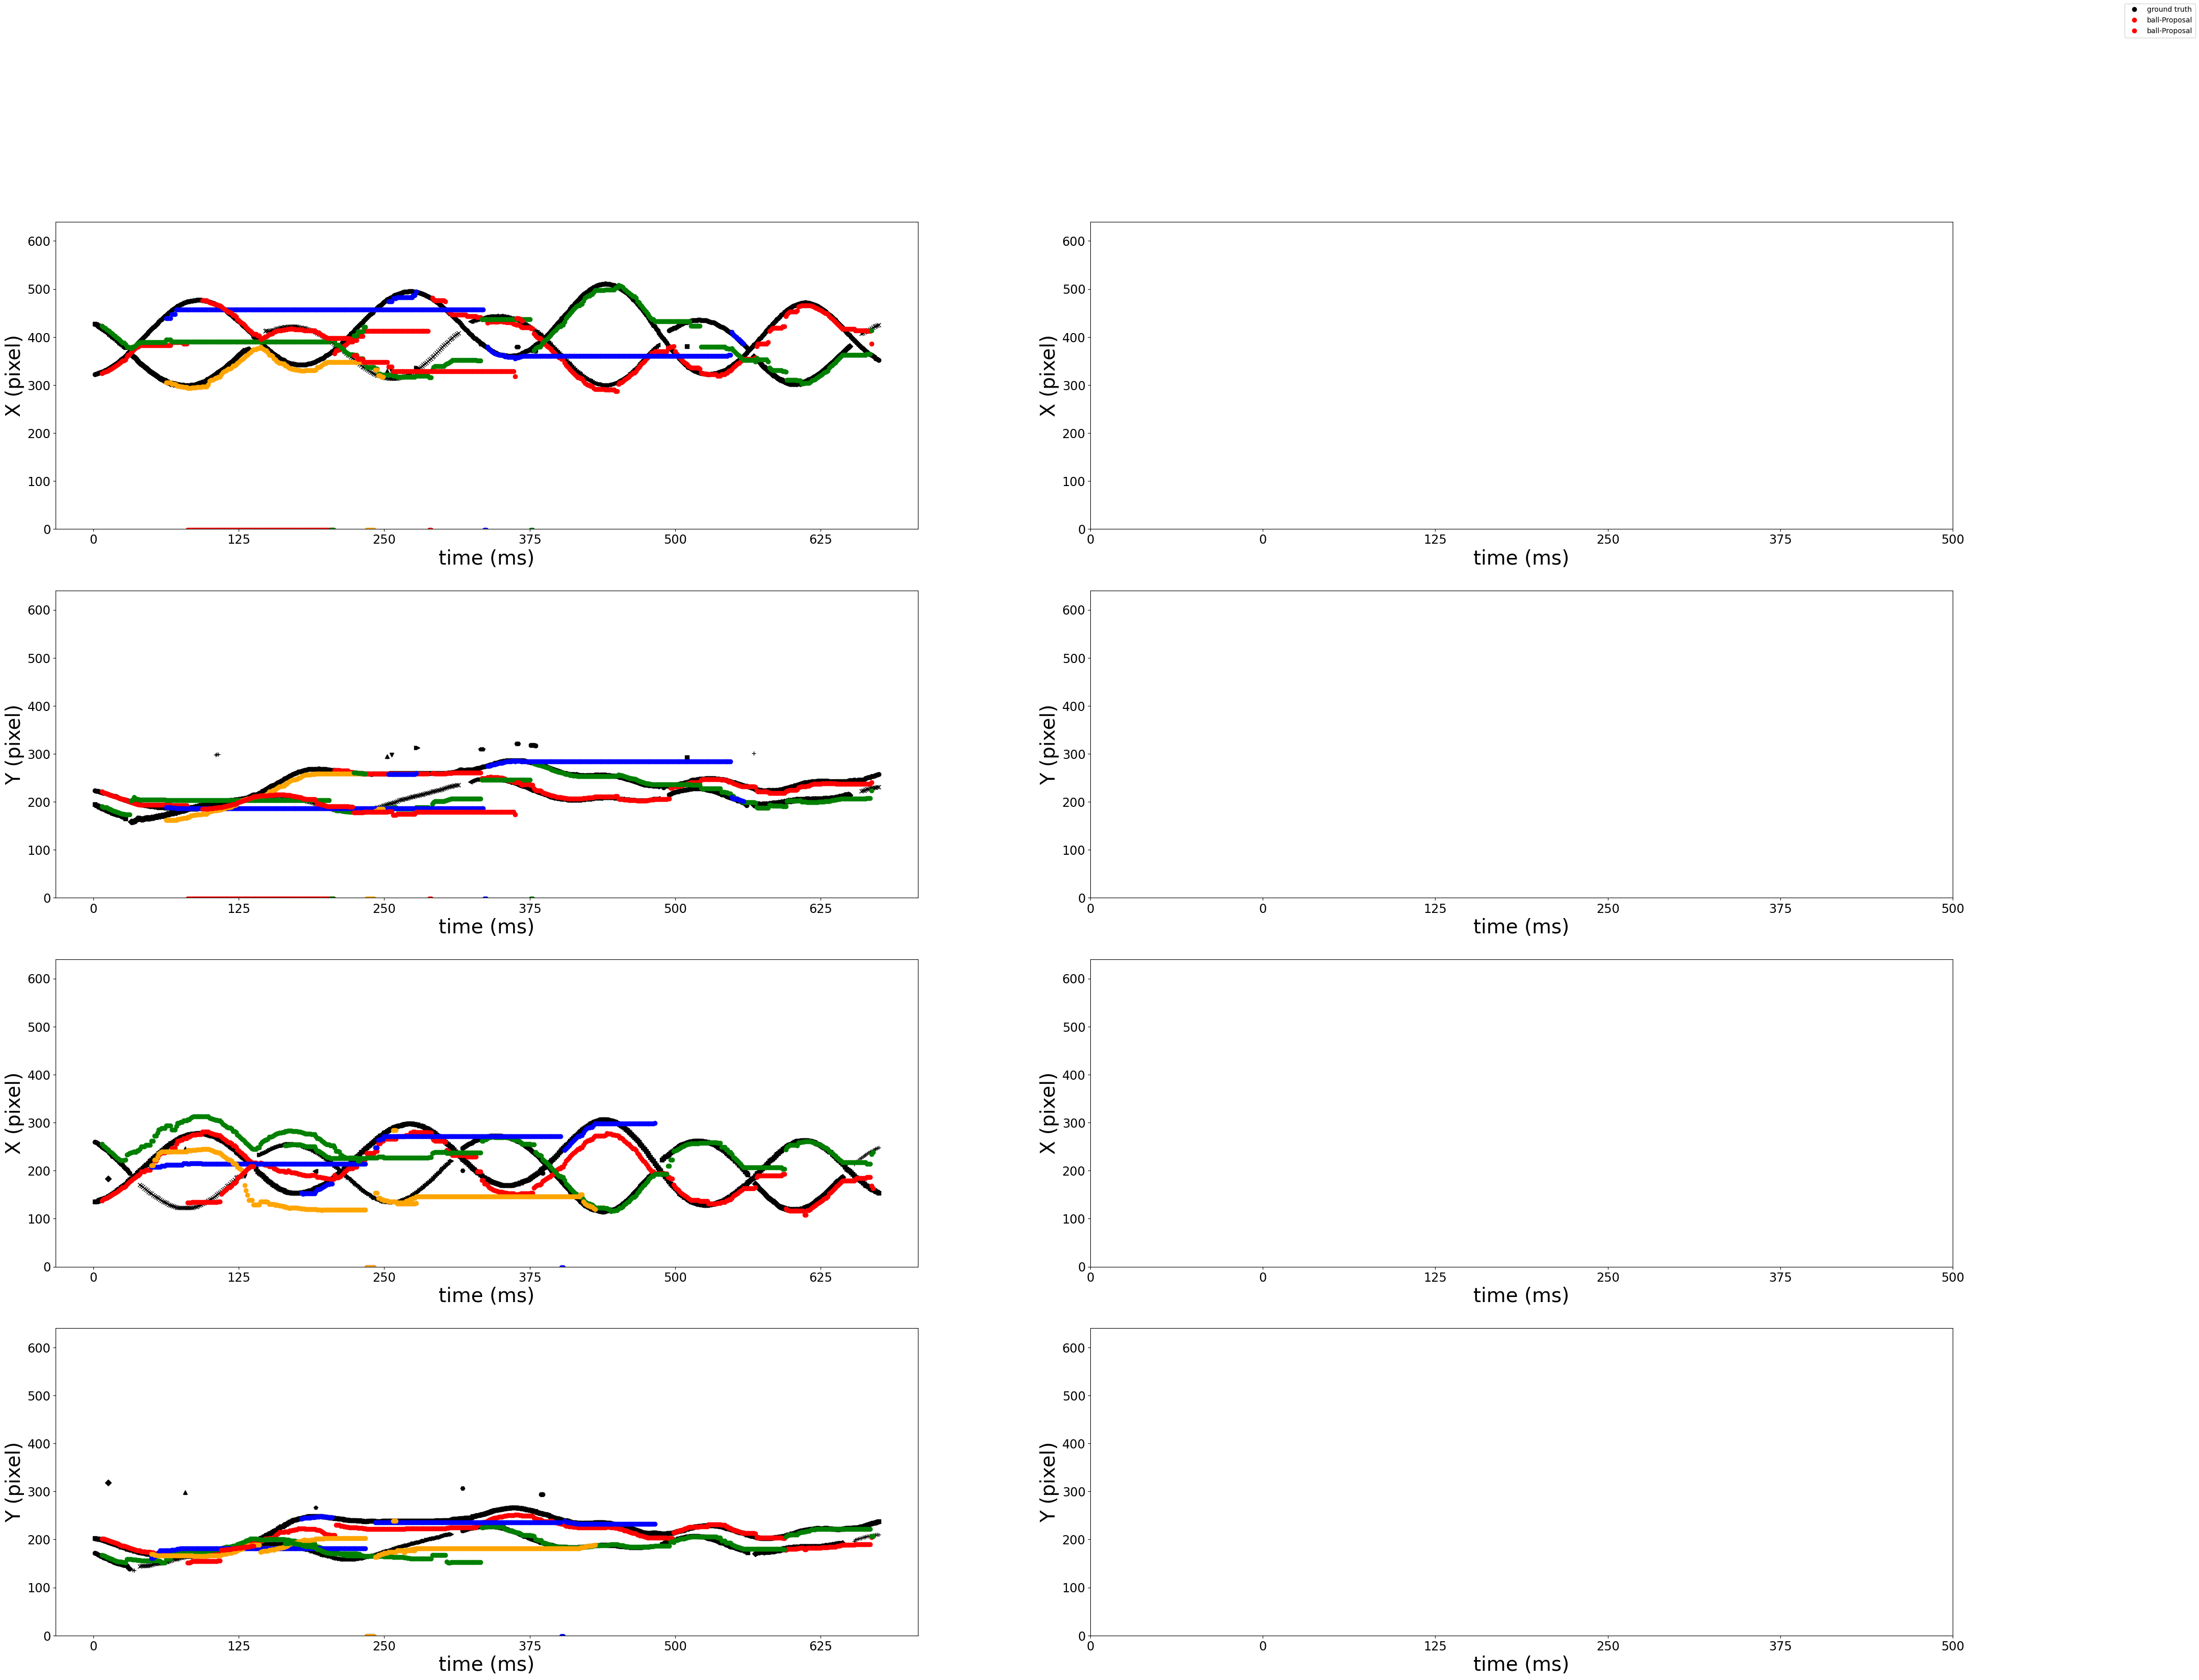

In [24]:
colors_seq = ["r","g","b","orange"]
colors_kf = ["r","g","b"]
marker_ball = "o"
marker_box = "D"
marker_ball_base = "x"
marker_box_base = "x"
colors_seq_base = ["c","m","y","hotpink"]
rt_data = "rt" #real-time data
kf_data = "kf" #kalman prediction data
fontSize=28
FPS=400
poss = ["Left","Right"]
types = ["BALL","BOX"]
axes = ["X","Y"]
titles = []
for pos in poss:
    for axis in axes:
        for type in types:
            titles.append(pos+"-"+axis+"-"+type)
fig,ax = plt.subplots(4,2,figsize=(48,36))
plotDataGT(data=dict_gt_left,color="k",data_name="rawData",pos="left",fps=FPS,fig=fig,ax=ax)
plotDataGT(data=dict_gt_right,color="k",data_name="rawData",pos="right",fps=FPS,fig=fig,ax=ax)
#Yolo+KF
#plotDataRT(dict_seq_frame_ball_left=dict_base_seq_frame_ball_left,dict_seq_frame_ball_right=dict_base_seq_frame_ball_right,dict_seq_frame_box_left=dict_base_seq_frame_box_left,dict_seq_frame_box_right=dict_base_seq_frame_box_right,
#             dict_seq_ball_left=dict_base_seq_ball_left, dict_seq_ball_right=dict_base_seq_ball_right,dict_seq_box_left=dict_base_seq_box_left,dict_seq_box_right=dict_base_seq_box_right,
#             colors_ball=colors_seq_base,colors_box=colors_seq_base,track_type="Conventional",alpha=0.99,fig=fig,ax=ax)
#TM+MOSSE+KF
plotDataRT(dict_seq_frame_ball_left=tmossekf_dict_seq_frame_ball_left,dict_seq_frame_ball_right=tmossekf_dict_seq_frame_ball_right,dict_seq_frame_box_left=tmossekf_dict_seq_frame_box_left,dict_seq_frame_box_right=tmossekf_dict_seq_frame_box_right,
             dict_seq_ball_left=tmossekf_dict_seqData_ball_left, dict_seq_ball_right=tmossekf_dict_seqData_ball_right,dict_seq_box_left=tmossekf_dict_seqData_box_left,dict_seq_box_right=tmossekf_dict_seqData_box_right,
             colors_ball=colors_seq,colors_box=colors_seq,track_type="Proposal",alpha=0.99,fig=fig,ax=ax)
#plotDataRT(dict_seq_frame_ball_left=tmossekf_dict_kf_frame_ball_left,dict_seq_frame_ball_right=tmossekf_dict_kf_frame_ball_right,dict_seq_frame_box_left=tmossekf_dict_kf_frame_box_left,dict_seq_frame_box_right=tmossekf_dict_kf_frame_box_right,
#             dict_seq_ball_left=tmossekf_dict_kfData_ball_left, dict_seq_ball_right=tmossekf_dict_kfData_ball_right,dict_seq_box_left=tmossekf_dict_kfData_box_left,dict_seq_box_right=tmossekf_dict_kfData_box_right,
#             colors_ball=colors_kf,colors_box=colors_kf,track_type=kf_data,alpha=0.8,fig=fig,ax=ax)
for i in range(4): #y
    for j in range(2): #x
        #if i== 0:
        #ax[i][j].legend()
        ax[i][j].set_ylim(0,640)
        #ax[i][j].set_xlim(0,300)
        ax[i][j].set_xlabel("time (ms)",fontsize=fontSize)
        if i%2 == 0:
            ax[i][j].set_ylabel("X (pixel)", fontsize=fontSize)
        if i%2 == 1:
            ax[i][j].set_ylabel("Y (pixel)", fontsize=fontSize)
        ax[i][j].set_yticklabels(np.arange(0,640,100),fontsize="xx-large")
        ax[i][j].set_xticklabels(x_label,fontsize="xx-large")
        #ax[i][j].set_xlim(0,300)
#ax[0,0].set_xlim(130,230)
#ax[1,0].set_xlim(130,230)
fig.legend()
#fig.savefig(r"C:\Users\kawaw\data_tracking\0111\switching\4\result\tracking_proposed.png")
plt.show()


### Evaluate data

#### revise data

##### YOLO&KF

In [ ]:
#rootDir = r"C:\Users\kawaw\cpp\objectTracking_yolo_kalmanfilter\objectTracking_yolo_kalmanfilter"
#rootDir = r"C:\Users\kawaw\data_tracking\0112\switching\changeTraj\csv\kf"
#rootDir = r"C:\Users\kawaw\data_tracking\0112\switching\accelerate\csv\kf"
#rootDir = r"C:\Users\kawaw\data_tracking\0119\objectTracking\ball_box\csv\kf"
#rootDir = r"C:\Users\kawaw\data_tracking\0119\objectTracking\ball2_throwing\csv\kf"
#switching3
rootDir = r"C:\Users\kawaw\data_tracking\0111\switching\2\result\YOLO_KF"#kf"
#rootDir = r"C:\Users\kawaw\data_tracking\0119\objectTracking\ball_box\csv\kf"
file_seq_ball_left = os.path.join(rootDir,"seqData_ball_left.csv")
file_seq_box_left = os.path.join(rootDir,"seqData_box_left.csv")
file_seq_ball_right = os.path.join(rootDir,"seqData_ball_right.csv")
file_seq_box_right = os.path.join(rootDir,"seqData_box_right.csv")
file_kf_ball_left = os.path.join(rootDir,"kfData_ball_left.csv")
file_kf_box_left = os.path.join(rootDir,"kfData_box_left.csv")
file_kf_ball_right = os.path.join(rootDir,"kfData_ball_right.csv")
file_kf_box_right = os.path.join(rootDir,"kfData_box_right.csv")

max_num = 300
seqData_ball_left = loadSeqData(max_num=max_num,file=file_seq_ball_left)
seqData_box_left = loadSeqData(max_num=max_num,file=file_seq_box_left)
seqData_ball_right = loadSeqData(max_num=max_num,file=file_seq_ball_right)
seqData_box_right = loadSeqData(max_num=max_num,file=file_seq_box_right)
kfData_ball_left = loadKfData(max_num=max_num,file=file_kf_ball_left)
kfData_box_left = loadKfData(max_num=max_num,file=file_kf_box_left)
kfData_ball_right = loadKfData(max_num=max_num,file=file_kf_ball_right)
kfData_box_right = loadKfData(max_num=max_num,file=file_kf_box_right)

In [ ]:
def seq2Seq(data,min_duration):
    """from sequential data to frameIndex and xCenter data

    Args:
        data (list):  {frameIndex, label, left, top, width, height}*(num detected frames)

    Return:
        dict_frames (dict) : {1: [1,2,3,,,], 2:[3,4,5,,,],,,} :: {num of objects, [frames]}
        dict_seqData (dict) : {1: [[2,2],[2,4],,,], 2:[[3,3],,],,} :: {num of objects, [[xCenter,yCenter]]}
    """
    counter = 0
    dict_frames = dict()
    dict_seqData = dict()
    for i in range(data.shape[0]): #for each objects
        counter = 1
        frames = []
        seqData = []
        #print(data.shape[1])
        while (data[i][counter*6]>0 and data.shape[1]):
            #if (len(frames)>0):
            #    if (frames[-1]>=300):
            #        break
            #print(frames)
            #print(counter*6)
            if (len(seqData)>0):
                while (frames[-1]<data[i][counter*6]-1): #compensate data
                    frames.append(frames[-1]+1)
                    seqData.append([seqData[-1][0],seqData[-1][1],seqData[-1][2],seqData[-1][3]])
            if (data[i][(counter)*6]>0):
                frames.append(data[i][counter*6])
                seqData.append([data[i][(counter-1)*6+2],data[i][(counter-1)*6+3],data[i][(counter-1)*6+4],+data[i][(counter-1)*6+5]]) #[xCenter,yCenter]
            else: #failed
                if (len(seqData)>0):
                    frames.append(frames[-1]+1)
                    seqData.append([seqData[-1][0],seqData[-1][1],seqData[-1][2],seqData[-1][3]])
            counter+=1
            if (counter*6>=data.shape[1]):
                break
        if (len(seqData)>=min_duration):
            #print(frames)
            dict_frames[i+1] = np.array(frames)
            dict_seqData[i+1] = np.array(seqData)
    return dict_frames, dict_seqData

In [ ]:
MIN_DURATION=10
#sequential data
dict_base_seq_frame_ball_left,dict_base_seq_ball_left = seq2Seq(data=seqData_ball_left,min_duration=MIN_DURATION)
dict_base_seq_frame_box_left,dict_base_seq_box_left = seq2Seq(data=seqData_box_left,min_duration=MIN_DURATION)
dict_base_seq_frame_ball_right,dict_base_seq_ball_right = seq2Seq(data=seqData_ball_right,min_duration=MIN_DURATION)
dict_base_seq_frame_box_right,dict_base_seq_box_right = seq2Seq(data=seqData_box_right,min_duration=MIN_DURATION)
#print(dict_base_seq_ball_left)

##### YOLO&MOSSE&KF

### Reload data

In [ ]:
#switching_accelerate
#rootDir = r"C:\Users\kawaw\data_tracking\0112\switching\accelerate\csv\realtime"
#switching_changeTrajectory
#rootDir = r"C:\Users\kawaw\data_tracking\0112\switching\changeTraj\csv\realtime"
#ball&box 0119
#rootDir = r"C:\Users\kawaw\data_tracking\0119\objectTracking\ball_box\csv\realtime"
#throwing2 
#rootDir = r"C:\Users\kawaw\data_tracking\0119\objectTracking\ball2_throwing\csv\realtime"
#throwing3
#rootDir = r"C:\Users\kawaw\data_tracking\0119\objectTracking\ball3_throwing"
#switching3
rootDir = r"C:\Users\kawaw\data_tracking\0111\switching\2\result\MOSSE_TM_KF_PSRCHECK_DUPLICATED_DYNAMICSEARCH_SKIP"
#rootDir = r"C:\Users\kawaw\data_tracking\0119\objectTracking\ball_box\csv\realtime"
#rootDir=r"C:\Users\kawaw\cpp\objectTracking_2cams_mosse_templatematching_kf\objectTracking_2cams_mosse_templatematching_kf"
#max objects
max_num = 3000

#TM+MOSSE_KF
tmossekfDir = os.path.join(rootDir)
tmossekf_file_seq_left = os.path.join(tmossekfDir,"seqData_left.csv")
tmossekf_file_seq_right = os.path.join(tmossekfDir,"seqData_right.csv")
tmossekf_seqData_left = loadSeqData(max_num=max_num,file=tmossekf_file_seq_left)
tmossekf_seqData_right = loadSeqData(max_num=max_num,file=tmossekf_file_seq_right)

In [ ]:
def seq2Seq(data):
    """from sequential data to frameIndex and xCenter data

    Args:
        data (list):  {frameIndex, label, left, top, width, height}*(num detected frames)

    Return:
        dict_frames_ball, dict_frames_box (dict) : {1: [1,2,3,,,], 2:[3,4,5,,,],,,} :: {num of objects, [frames]}
        dict_seqData_ball, dice_seqData_box (dict) : {1: [[2,2],[2,4],,,], 2:[[3,3],,],,} :: {num of objects, [[xCenter,yCenter]]}
    """
    counter = 0
    num_ball = 0
    num_box = 0
    dict_frames_ball = dict()
    dict_seqData_ball = dict()
    dict_frames_box = dict()
    dict_seqData_box = dict()
    for i in range(data.shape[0]): #for each objects
        counter = 1
        frames = []
        seqData = []
        #print(data.shape[1])
        while (data[i][counter*6] != -2 and  data.shape[1]):
            #if (len(frames)>0):
            #    if (frames[-1]>=300):
            #        break
            #print(counter*6)
            if (len(seqData)>0):
                while (frames[-1]<data[i][counter*6]-1): #compensate data
                    frames.append(frames[-1]+1)
                    seqData.append([seqData[-1][0],seqData[-1][1],seqData[-1][2],seqData[-1][3]])
            if (data[i][counter*6+2]>0): #detected
                frames.append(data[i][counter*6])
                seqData.append([data[i][(counter-1)*6+2],data[i][(counter-1)*6+3],data[i][(counter-1)*6+4],data[i][(counter-1)*6+5]]) #[xCenter,yCenter]
            else: #failed
                if (len(seqData))>0:
                    frames.append(frames[-1]+1)
                    seqData.append([seqData[-1][0],seqData[-1][1],seqData[-1][2],seqData[-1][3]])
            counter+=1
            if (counter*6>=data.shape[1]):
                break
        if (data[i][1] == 0 and len(frames)>5): #ball
            num_ball += 1
            dict_frames_ball[num_ball] = np.array(frames)
            dict_seqData_ball[num_ball] = np.array(seqData)
            print(np.array(frames).shape,np.array(seqData).shape)
        elif (data[i][1] == 1 and len(frames)>5): #box
            num_box += 1
            dict_frames_box[num_box] = np.array(frames)
            dict_seqData_box[num_box] = np.array(seqData)
            print(np.array(frames).shape,np.array(seqData).shape)
    return dict_frames_ball, dict_seqData_ball,dict_frames_box, dict_seqData_box

In [ ]:
#tm+mosse+kf
tmossekf_dict_seq_frame_ball_left,tmossekf_dict_seqData_ball_left,tmossekf_dict_seq_frame_box_left,tmossekf_dict_seqData_box_left = seq2Seq(data=tmossekf_seqData_left)
tmossekf_dict_seq_frame_ball_right,tmossekf_dict_seqData_ball_right,tmossekf_dict_seq_frame_box_right,tmossekf_dict_seqData_box_right = seq2Seq(data=tmossekf_seqData_right)


In [ ]:
def rmse(x0,y0,x1,y1):
    return ((x0-x1)**2+(y0-y1)**2)**(1/2)

def iou(data1,data2):
    """calculate IoU (intersection over union)

    Args:
        data1 (list): real-time data ([left, top, width, height])
        data2 (_type_): ground truth data
    """
    left_1 = data1[0]
    top_1 = data1[1]
    right_1 = left_1 + data1[2]
    bottom_1 = top_1 + data1[3]
    left_2 = data2[0]
    top_2 = data2[1]
    right_2 = left_2 + data2[2]
    bottom_2 = top_2 + data2[3]
    left_i = max(left_1,left_2)
    top_i = max(top_1,top_2)
    right_i = min(right_1,right_2)
    bottom_i = min(bottom_1,bottom_2)
    if ((right_i - left_i)>0 and (bottom_i - top_i)>0):
        intersection = (right_i-left_i)*(bottom_i-top_i)
        union = (right_1-left_1)*(bottom_1-top_1) + (right_2-left_2)*(bottom_2-top_2) - intersection
        iou = intersection/union
        return iou
    else:
        return 0.0

In [ ]:
def compare(dict_frame_ball,dict_data_ball,tempFrameGT,tempPositionXGT,tempPositionYGT,tempBboxGT,rmseBall,iouBall):
    """compare real-time data with groung truth

    Args:
        dict_frame_ball (_type_): frames
        dict_data_ball (_type_): seq data : {left,top,width,height}
        tempFrameGT (_type_): ground truth frames
        tempPositionXGT (_type_): ground truth : centerX
        tempPositionYGT (_type_): ground truth : centerY
        tempBboxGT (_type_): ground truth : bbox
        rmseBall (_type_): result : rmseBall
        iouBall (_type_): result : iouBall
    Retrun 
        rmseBall, iouBall
    """
    for key_frame,key_data in zip(dict_frame_ball,dict_data_ball):
        indexes = dict_frame_ball[key_frame] #frame index
        seqData = dict_data_ball[key_data] #sequential data
        #print(seqData.shape)
        for i in range(indexes.shape[0]): #for every frame
            frame = indexes[i]
            #if frame>300:
            #    break
            centerX = seqData[i][0]+seqData[i][2]/2
            centerY = seqData[i][1]+seqData[i][3]/2
            #if frame>300:
            #    break
            #print(frame)
            if frame in tempFrameGT: #there is a matched frame -> calculate RMSE and IoU
                index = np.where(tempFrameGT==int(frame))[0]
                #print(index)
                if (len(index)>=2):
                    idx = index[-1]
                else:
                    idx = index[0]
                centerXGT = tempPositionXGT[idx] #ground truth : xCenter
                centerYGT = tempPositionYGT[idx] #ground truth : yCenter
                RMSE = rmse(centerXGT,centerYGT,centerX,centerY) #RMSE
                #print(seqData[i],tempBboxGT[idx])
                IoU = iou(seqData[i],tempBboxGT[idx]) #IoU
                #print(IoU)
                #add data
                if not frame in rmseBall: #no RMSE
                    rmseBall[frame] = RMSE
                else: #already have RMSE
                    if RMSE<rmseBall[frame]:
                        rmseBall[frame] = RMSE
                #iou data
                if not frame in iouBall: #no RMSE
                    iouBall[frame] = IoU
                else: #already have RMSE
                    if IoU>iouBall[frame]:
                        iouBall[frame] = IoU
    return rmseBall,iouBall

def evaluation(dict_gt,dict_frame_ball,dict_frame_box,dict_data_ball,dict_data_box):
    """calculate RMSE and sequence data for each label-> available for only 2 objects evaluation

    Args:
        dict_gt (dict) : Ground truth :: {frame,left,top,width,height}
        dict_frame_ball,dict_frame_box (dict) : {1:[1,2,3],2:[3,4,5,,]}
        dict_data_ball,dict_data_box : {1:[[left,top,width,height],[,,]],2:}  
    Return:
        rmseBall,rmseBox,iouBall,iouBox,sequenceBall,sequenceBox (dict) : rmse, IoU and sequential data
    """
    #prepare dictionary for saving data
    #for all ground truth data
    rmseBalls = dict()
    iouBalls = dict()
    rmseBoxes = dict()
    iouBoxes = dict()
    #Ground Truth
    #for every ground truth data :: compare real-time data with ground truth data
    for keyGT in dict_gt:
        #for each ground truth data
        rmseBall = dict() #[frameIndex,rmse]
        rmseBox = dict()
        iouBall = dict() #[frameIndex,iou]
        iouBox = dict()
        #print("Ground truth = ",keyGT)
        labelGT = keyGT.split("-")[0] #label : ball or box
        tempDataGT = dict_gt[keyGT]
        tempFrameGT = []
        tempPositionXGT = []
        tempPositionYGT = []
        tempBboxGT = []
        for i in range(len(tempDataGT)):
            tempFrameGT.append(tempDataGT[i][0]) #frameIndex
            tempBboxGT.append(tempDataGT[i][1:]) #[left,top,width,height]
            centerX = tempDataGT[i][1]+tempDataGT[i][3]/2
            centerY = tempDataGT[i][2]+tempDataGT[i][4]/2
            tempPositionXGT.append(centerX)
            tempPositionYGT.append(centerY)
        tempFrameGT = np.array(tempFrameGT)
        tempBboxGT = np.array(tempBboxGT)
        tempPositionXGT = np.array(tempPositionXGT)
        tempPositionYGT = np.array(tempPositionYGT)
        #print(labelGT)
        if labelGT.lower() == "ball": #ball
            rmseBall,iouBall = compare(dict_frame_ball=dict_frame_ball,dict_data_ball=dict_data_ball,tempFrameGT=tempFrameGT,
                                       tempPositionXGT=tempPositionXGT,tempPositionYGT=tempPositionYGT,tempBboxGT=tempBboxGT,rmseBall=rmseBall,iouBall=iouBall)
            rmseBalls[keyGT] = rmseBall
            iouBalls[keyGT] = iouBall
        elif labelGT.lower() == "box":
            #print("box")
            rmseBox,iouBox = compare(dict_frame_ball=dict_frame_box,dict_data_ball=dict_data_box,tempFrameGT=tempFrameGT,
                                       tempPositionXGT=tempPositionXGT,tempPositionYGT=tempPositionYGT,tempBboxGT=tempBboxGT,rmseBall=rmseBox,iouBall=iouBox)
            rmseBoxes[keyGT] = rmseBox
            iouBoxes[keyGT] = iouBox
                        
    return rmseBalls,rmseBoxes,iouBalls,iouBoxes

In [ ]:
#TM+MOSSE
tmossekf_rmseBall_left,tmossekf_rmseBox_left,tmossekf_iouBall_left,tmossekf_iouBox_left = evaluation(dict_gt=dict_gt_left,dict_frame_ball=tmossekf_dict_seq_frame_ball_left,
                                                                 dict_frame_box=tmossekf_dict_seq_frame_box_left,dict_data_ball=tmossekf_dict_seqData_ball_left,dict_data_box=tmossekf_dict_seqData_box_left)
tmossekf_rmseBall_right,tmossekf_rmseBox_right,tmossekf_iouBall_right,tmossekf_iouBox_right = evaluation(dict_gt=dict_gt_right,dict_frame_ball=tmossekf_dict_seq_frame_ball_right,
                                                                     dict_frame_box=tmossekf_dict_seq_frame_box_right,dict_data_ball=tmossekf_dict_seqData_ball_right,dict_data_box=tmossekf_dict_seqData_box_right)
#YOLO&KF
rmseBall_left_base,rmseBox_left_base,iouBall_left_base,iouBox_left_base = evaluation(dict_gt=dict_gt_left,dict_frame_ball=dict_base_seq_frame_ball_left,
                                                                 dict_frame_box=dict_base_seq_frame_box_left,dict_data_ball=dict_base_seq_ball_left,dict_data_box=dict_base_seq_box_left)
rmseBall_right_base,rmseBox_right_base,iouBall_right_base,iouBox_right_base = evaluation(dict_gt=dict_gt_right,dict_frame_ball=dict_base_seq_frame_ball_right,
                                                                    dict_frame_box=dict_base_seq_frame_box_right,dict_data_ball=dict_base_seq_ball_right,dict_data_box=dict_base_seq_box_right)

## Extract rmse and IoU data for each ground truth data
- 2 objects version

In [ ]:
import random
def rmseExtraction(rmseData,numObjects=2):
    dict_rmse = dict()
    if (len(rmseData)>0):
        for keyGT in rmseData:
            frame_list = list(rmseData[keyGT].keys())
            for frame in frame_list:
                if frame not in dict_rmse:
                    dict_rmse[frame] = [rmseData[keyGT][frame]]
                else:
                    dict_rmse[frame].append(rmseData[keyGT][frame])
        #combine all data
        data_list = []
        for frame in dict_rmse:
            temp = []
            temp.append(frame)
            if (len(dict_rmse[frame])>=numObjects):
                sorted_list = sorted(np.array(dict_rmse[frame]))
                for i in range(numObjects):    
                    temp.append(sorted_list[i])
            else:
                if (len(dict_rmse[frame])>0):
                    sorted_list = sorted(np.array(dict_rmse[frame]))
                    for i in range(numObjects):
                        if i<len(sorted_list):
                            temp.append(sorted_list[i])
                        else:
                            temp.append(None)
                else:
                    for i in range(numObjects):
                        temp.append(None)
            data_list.append(temp)
            #print(len(temp))
        if len(data_list)>0:
            data_list = np.array(data_list)
            result_dict = dict()
            averageRMSE = []
            mean_rmse = 0
            for i in range(numObjects):
                result_dict[i] = np.array(np.array([x if x is not None else np.nan for x in data_list[:,i+1]]))
                averageRMSE.append(round(np.nanmean(result_dict[i]),2))
                print("RMSE=",round(np.nanmean(result_dict[i]),2))
                mean_rmse += round(np.nanmean(result_dict[i]),2)
            #print(second_smallest_array)
            #if mean_rmse!=np.nan:
            #    print(f"average RMSE = {round(mean_rmse/numObjects)}")
            return averageRMSE,data_list
        else:
            print("no data")
            return [0],np.array([])
    else:
        print("no data")
        return [0],np.array([])

def iouExtraction(iouData,numObjects):
    dict_iou = dict()
    if (len(iouData)>0):
        for keyGT in iouData:
            frame_list = list(iouData[keyGT].keys())
            for frame in frame_list:
                if frame not in dict_iou:
                    dict_iou[frame] = [iouData[keyGT][frame]]
                else:
                    dict_iou[frame].append(iouData[keyGT][frame])
        #combine all data
        data_list = []
        for frame in dict_iou:
            temp = []
            temp.append(frame)
            if (len(dict_iou[frame])>=numObjects):
                sorted_list = sorted(np.array(dict_iou[frame]))
                #temp.append(frame)
                for i in range(1,numObjects+1):
                    temp.append(sorted_list[-i])
            else:
                if (len(dict_iou[frame])>0):
                    sorted_list = sorted(np.array(dict_iou[frame]))
                    for i in range(1,numObjects+1):
                        if i<len(sorted_list):
                            temp.append(sorted_list[-i])
                        else:
                            temp.append(0)
                else:
                    for i in range(numObjects):
                        temp.append(0)
            data_list.append(temp)
        if len(data_list)>0:
            data_list = np.array(data_list)
            result_dict = dict()
            averageIoU = []
            mean_iou = 0
            for i in range(numObjects):
                result_dict[i] = np.array(np.array([x if x is not None else np.nan for x in data_list[:,i+1]]))
                averageIoU.append(round(np.nanmean(result_dict[i]),2))
                print("IoU=",round(np.nanmean(result_dict[i]),2))
                mean_iou += round(np.nanmean(result_dict[i]),2)
            #print(second_smallest_array)
            #if mean_iou!=np.nan:
            #    print(f"average IoU = {round(mean_iou/numObjects)}")
            return averageIoU,data_list
        else:
            print("no data")
            return [0],np.array([])
    else:
        print("no data")
        return [0],np.array([])
    
def extraction(rmseData,iouData,numObjects=2,bool_adjust=False):
    #rmse
    dict_rmse = dict()
    dict_iou = dict()
    if (len(rmseData)>0) and (len(iouData)>0): 
        for keyGT in rmseData:
            frame_list = list(rmseData[keyGT].keys())
            for frame in frame_list:
                if frame not in dict_rmse:
                    dict_rmse[frame] = [rmseData[keyGT][frame]]
                    dict_iou[frame] = [iouData[keyGT][frame]]
                else:
                    dict_rmse[frame].append(rmseData[keyGT][frame])
                    dict_iou[frame].append(iouData[keyGT][frame])
        #combine all data
        data_list_rmse = []
        data_list_iou = []
        for frame in dict_rmse:
            temp_rmse = []
            temp_iou = []
            temp_rmse.append(frame)
            temp_iou.append(frame)
            if (len(dict_rmse[frame])>=numObjects):
                sorted_list_rmse = sorted(np.array(dict_rmse[frame]))
                sorted_list_iou = sorted(np.array(dict_iou[frame]))
                for i in range(numObjects):    
                    temp_rmse.append(sorted_list_rmse[i])
                    temp_iou.append(sorted_list_iou[-(i+1)])
            else:
                if (len(dict_rmse[frame])>0):
                    sorted_list_rmse = sorted(np.array(dict_rmse[frame]))
                    sorted_list_iou = sorted(np.array(dict_iou[frame]))
                    for i in range(numObjects):
                        if i<len(sorted_list_rmse):
                            temp_rmse.append(sorted_list_rmse[i])
                            temp_iou.append(sorted_list_iou[-(i+1)])
                        else:
                            temp_rmse.append(None)
                            temp_iou.append(None)
                else:
                    for i in range(numObjects):
                        temp_rmse.append(None)
                        temp_iou.append(None)
            data_list_rmse.append(temp_rmse)
            data_list_iou.append(temp_iou)
            #print(len(temp))
        if len(data_list_rmse)>0:
            data_list_rmse = np.array(data_list_rmse)
            data_list_iou = np.array(data_list_iou)
            result_dict_rmse = dict()
            result_dict_iou = dict()
            averageRMSE = []
            mean_rmse = 0
            averageIoU = []
            mean_iou = 0
            for i in range(numObjects):
                result_dict_rmse[i] = np.array(np.array([x if x is not None else np.nan for x in data_list_rmse[:,i+1]]))
                averageRMSE.append(round(np.nanmean(result_dict_rmse[i]),2))
                print("RMSE=",round(np.nanmean(result_dict_rmse[i]),2))
                mean_rmse += round(np.nanmean(result_dict_rmse[i]),2)
                result_dict_iou[i] = np.array(np.array([x if x is not None else np.nan for x in data_list_iou[:,i+1]]))
                averageIoU.append(round(np.nanmean(result_dict_iou[i]),2))
                print("IoU=",round(np.nanmean(result_dict_iou[i]),2))
                mean_iou += round(np.nanmean(result_dict_iou[i]),2)
            #print(second_smallest_array)
            #if mean_rmse!=np.nan:
            #    print(f"average RMSE = {round(mean_rmse/numObjects)}")
            return averageRMSE,averageIoU,data_list_rmse,data_list_iou
        else:
            print("no data")
            return [0],[0],np.array([]),np.array([])
    else:
        print("no data")
        return [0],[0],np.array([]),np.array([])

In [ ]:
NUM=2
#TM+MOSSE+KF
print(" ~~~~ TM+MOSSE+KF ~~~~")
#tmossekf_aveRMSE_ball_left, tmossekf_rmse_ball_left = rmseExtraction(tmossekf_rmseBall_left,numObjects=NUM)
#tmossekf_aveRMSE_ball_right,tmossekf_rmse_ball_right = rmseExtraction(tmossekf_rmseBall_right,numObjects=NUM)
#tmossekf_aveRMSE_box_left, tmossekf_rmse_box_left = rmseExtraction(tmossekf_rmseBox_left,numObjects=NUM)
#tmossekf_aveRMSE_box_right,tmossekf_rmse_box_right = rmseExtraction(tmossekf_rmseBox_right,numObjects=NUM)
#tmossekf_aveIoU_ball_left, tmossekf_iou_ball_left = iouExtraction(tmossekf_iouBall_left,numObjects=NUM)
#tmossekf_aveIoU_ball_right,tmossekf_iou_ball_right = iouExtraction(tmossekf_iouBall_right,numObjects=NUM)
#tmossekf_aveIoU_box_left, tmossekf_iou_box_left = iouExtraction(tmossekf_iouBox_left,numObjects=NUM)
#tmossekf_aveIoU_box_right,tmossekf_iou_box_right = iouExtraction(tmossekf_iouBox_right,numObjects=NUM)
tmossekf_aveRMSE_ball_left,tmossekf_aveIoU_ball_left, tmossekf_rmse_ball_left, tmossekf_iou_ball_left = extraction(tmossekf_rmseBall_left,tmossekf_iouBall_left,numObjects=NUM)
tmossekf_aveRMSE_ball_right,tmossekf_aveIoU_ball_right, tmossekf_rmse_ball_right, tmossekf_iou_ball_right = extraction(tmossekf_rmseBall_right,tmossekf_iouBall_right,numObjects=NUM)
tmossekf_aveRMSE_box_left,tmossekf_aveIoU_box_left, tmossekf_rmse_box_left, tmossekf_iou_box_left = extraction(tmossekf_rmseBox_left,tmossekf_iouBox_left,numObjects=NUM)
tmossekf_aveRMSE_box_right,tmossekf_aveIoU_box_right, tmossekf_rmse_box_right, tmossekf_iou_box_right = extraction(tmossekf_rmseBox_right,tmossekf_iouBox_right,numObjects=NUM)
#YOLO&KF
print(" == YOLO+KF == ")
#aveRMSE_ball_left_base, rmse_ball_left_base = rmseExtraction(rmseBall_left_base,numObjects=NUM)
#aveRMSE_ball_right_base, rmse_ball_right_base = rmseExtraction(rmseBall_right_base,numObjects=NUM)
#aveRMSE_box_left_base, rmse_box_left_base = rmseExtraction(rmseBox_left_base,numObjects=NUM)
#aveRMSE_box_right_base, rmse_box_right_base = rmseExtraction(rmseBox_right_base,numObjects=NUM)
#aveIoU_ball_left_base, iou_ball_left_base = iouExtraction(iouBall_left_base,numObjects=NUM)
#aveIoU_ball_right_base, iou_ball_right_base = iouExtraction(iouBall_right_base,numObjects=NUM)
#aveIoU_box_left_base, iou_box_left_base = iouExtraction(iouBox_left_base,numObjects=NUM)
#aveIoU_box_right_base, iou_box_right_base = iouExtraction(iouBox_right_base,numObjects=NUM)
aveRMSE_ball_left_base,aveIoU_ball_left_base, rmse_ball_left_base,iou_ball_left_base = extraction(rmseBall_left_base,iouBall_left_base,numObjects=NUM)
aveRMSE_ball_right_base,aveIoU_ball_right_base, rmse_ball_right_base,iou_ball_right_base = extraction(rmseBall_right_base,iouBall_right_base,numObjects=NUM)
aveRMSE_box_left_base,aveIoU_box_left_base, rmse_box_left_base,iou_box_left_base = extraction(rmseBox_left_base,iouBox_left_base,numObjects=NUM)
aveRMSE_box_right_base,aveIoU_box_right_base, rmse_box_right_base,iou_box_right_base = extraction(rmseBox_right_base,iouBox_right_base,numObjects=NUM)

In [ ]:
x_label = [0]+[i for i in range(0,351,50)]
x_label_box = [i for i in range(0,1401,200)]
print(x_label)

In [ ]:
print(tmossekf_rmse_ball_left)
for i in range(tmossekf_rmse_ball_left.shape[0]):
    if (tmossekf_rmse_ball_left[i][0]!=np.nan):
        tmossekf_rmse_ball_left[i][0] = tmossekf_rmse_ball_left[i][0]*2.5
for i in range(tmossekf_iou_ball_left.shape[0]):
    if (tmossekf_iou_ball_left[i][0]!=np.nan):
        tmossekf_iou_ball_left[i][0] =tmossekf_iou_ball_left[i][0]*2.5

for i in range(rmse_ball_left_base.shape[0]):
    if (rmse_ball_left_base[i][0]!=np.nan):
        rmse_ball_left_base[i][0] =rmse_ball_left_base[i][0]*2.5
for i in range(iou_ball_left_base.shape[0]):
    if (iou_ball_left_base[i][0]!=np.nan):
        iou_ball_left_base[i][0] =iou_ball_left_base[i][0]*2.5

In [ ]:
Y_lim_rmse = 100
Y_lim_iou = 1.01
NUM = 2
#X_lim = 230
boolInclude_base = False
COLOR_propose = ["r","g","b","orange"]
COLOR_kf = ["c","m","y","hotpink"]
COLOR_TMOSSE = ["r","b"]
COLOR_BASE="k"
fontSize_legend=16
fontSize_label=24

def plotRT_eval(rmse_ball_left,rmse_ball_right,rmse_box_left,rmse_box_right,
                aveRMSE_ball_left,aveRMSE_ball_right,aveRMSE_box_left,aveRMSE_box_right,
                iou_ball_left,iou_ball_right,iou_box_left,iou_box_right,
                aveIoU_ball_left,aveIoU_ball_right,aveIoU_box_left,aveIoU_box_right,
                tracker,color,numObjects,
                fig,ax):
    #rmse : ball
    if (rmse_ball_left.shape[0]>0):
        for i in range(numObjects):
            ax[0,0].plot(rmse_ball_left[:,0],rmse_ball_left[:,i+1],color=color[i],linestyle="-",label=f"mean RMSE({tracker})={aveRMSE_ball_left[i]}")
    if (rmse_ball_right.shape[0]>0):
        for i in range(numObjects):
         ax[0,1].plot(rmse_ball_right[:,0],rmse_ball_right[:,i+1],color=color[i],linestyle="-",label=f"mean RMSE({tracker})={aveRMSE_ball_right[i]}")
    #rmse : box
    if (rmse_box_left.shape[0]>0):
        for i in range(numObjects):
            ax[1,0].plot(rmse_box_left[:,0],rmse_box_left[:,i+1],color=color[i],linestyle="-",label=f"mean RMS({tracker})={aveRMSE_box_left[i]}")
    if (rmse_box_right.shape[0]>0):
        for i in range(numObjects):
            ax[1,1].plot(rmse_box_right[:,0],rmse_box_right[:,i+1],color=color[i],linestyle="-",label=f"mean RMSE({tracker}={aveRMSE_box_right[i]}")
    #ball iou
    if (iou_ball_left.shape[0]>0):
        for i in range(numObjects):
            ax[2,0].plot(iou_ball_left[:,0],iou_ball_left[:,i+1],color=color[i],linestyle="-",label=f"mean IoU({tracker})={aveIoU_ball_left[i]}")
    if (iou_ball_right.shape[0]>0):
        for i in range(numObjects):
            ax[2,1].plot(iou_ball_right[:,0],iou_ball_right[:,i+1],color=color[i],linestyle="-",label=f"mean IoU({tracker})={aveIoU_ball_right[i]}")
        
    #box iou
    if (iou_box_left.shape[0]>0):
        for i in range(numObjects):
            ax[3,0].plot(iou_box_left[:,0],iou_box_left[:,i+1],color=color[i],linestyle="-",label=f"mean IoU({tracker})={aveIoU_box_left[i]}")
    if (iou_box_right.shape[0]>0):
        for i in range(numObjects):
            ax[3,1].plot(iou_box_right[:,0],iou_box_right[:,i+1],color=color[i],linestyle="-",label=f"mean IoU({tracker})={aveIoU_box_right[i]}")

fig,ax = plt.subplots(4,2,figsize=(36,36))

#TM+MOSSE+KF
plotRT_eval(tmossekf_rmse_ball_left,tmossekf_rmse_ball_right,tmossekf_rmse_box_left,tmossekf_rmse_box_right,
           tmossekf_aveRMSE_ball_left,tmossekf_aveRMSE_ball_right,tmossekf_aveRMSE_box_left,tmossekf_aveRMSE_box_right,
           tmossekf_iou_ball_left,tmossekf_iou_ball_right,tmossekf_iou_box_left,tmossekf_iou_box_right,
            tmossekf_aveIoU_ball_left,tmossekf_aveIoU_ball_right,tmossekf_aveIoU_box_left,tmossekf_aveIoU_box_right,
            tracker="proposal",color=COLOR_propose,numObjects=NUM,
            fig=fig,ax=ax)

#YOLO+KF
plotRT_eval(rmse_ball_left_base,rmse_ball_right_base,rmse_box_left_base,rmse_box_right_base,
            aveRMSE_ball_left_base,aveRMSE_ball_right_base,aveRMSE_box_left_base,aveRMSE_box_right_base,
            iou_ball_left_base,iou_ball_right_base,iou_box_left_base,iou_box_right_base,
           aveIoU_ball_left_base,aveIoU_ball_right_base,aveIoU_box_left_base,aveIoU_box_right_base,
           tracker="Convnentional",color=COLOR_kf,numObjects=NUM,
          fig=fig,ax=ax)
#ball rmse
#ax[2,0].set_xlim(0,X_lim)
#ax[2,1].set_xlim(0,X_lim)
for i in range(4):
    for j in range(2):
        if (i==0 or i==1):
            ax[i,j].legend(loc="upper right",fontsize=fontSize_legend)
            ax[i,j].set_ylabel("RMSE (pixel)",fontsize=fontSize_label)
            ax[i,j].set_yticklabels(np.arange(0,Y_lim_rmse+1,20),fontsize="xx-large")
            ax[i,j].set_ylim(0,Y_lim_rmse)
            #if (i==1 and j==1):
            #ax[i,j].set_xticklabels([0,150,300,450,600,750],fontsize="xx-large")
            #else:
            ax[i,j].set_xticklabels(x_label,fontsize="xx-large")
        else:
            ax[i,j].legend(loc="lower left",fontsize=fontSize_legend)
            ax[i,j].set_ylabel("IoU",fontsize=fontSize_label)
            ax[i,j].set_yticklabels([0,0.2,0.4,0.6,0.8,1.0],fontsize="xx-large")
            #ax[i,j].set_xticklabels(x_label,fontsize="xx-large")
            ax[i,j].set_ylim(0,1.0)
            #if (i==3 and j==1):
            #ax[i,j].set_xticklabels([0,150,300,450,600,750],fontsize="xx-large")
            #else:
            ax[i,j].set_xticklabels(x_label,fontsize="xx-large")
        ax[i,j].set_xlabel("time (ms)",fontsize=fontSize_label)
#fig.savefig(r"C:\Users\kawaw\data_tracking\0111\switching\4\result\rmse_iou.png")
plt.show()

### Make video

#### draw rectangle

In [ ]:
import glob
import cv2
import os
import re

def drawRectangle(dict_frame_ball,dict_frame_box,dict_data_ball,dict_data_box,src,saveDir):
    """draw rectangle in images

    Args:
        data (dict): sequence data of each tracker
        colorBall,colorBox(list) : rectangle color
        boolgroundTruth (bool) : if ground truth or not
        src (_type_, optional): path to source directory
        saveDir (_type_, optional): path to save directory
    """
    if not os.path.exists(saveDir):
        os.makedirs(saveDir)
    # Use glob to find all image files in the directory
    image_files = glob.glob(os.path.join(src, '*.png'))
    
    numBall = len(dict_data_ball)
    numBox = len(dict_data_box)
    counter_image = 1
    for image_file in image_files: #for every images
        #if (counter_image>300):
        #    break
        frame = cv2.imread(image_file)
        #ball detection
        counter_ball = 1
        for key_frame,key_data in zip(dict_frame_ball,dict_data_ball): #for evry trackers
            indexes = dict_frame_ball[key_frame] #frame index for ball
            seqData = dict_data_ball[key_data] #sequential data for ball
            if (counter_image in indexes): #detetion is available -> get matched index
                index = np.where(indexes == counter_image)[0]
                if (len(index)>=2):
                    idx = index[-1]
                else:
                    idx = index[0]
                bbox = seqData[idx] #bbox
                cv2.rectangle(frame,(int(bbox[0]),int(bbox[1])),(int(bbox[0]+bbox[2]),int(bbox[1]+bbox[3])),color=[int(100*counter_ball%255),0,int(125*counter_ball%255)],thickness=2) #[0,0,abs(255-numBall*20)%255]
            counter_ball += 1
        #box detection
        counter_box = 1
        for key_frame,key_data in zip(dict_frame_box,dict_data_box): #for evry trackers
            indexes = dict_frame_box[key_frame] #frame index for ball
            seqData = dict_data_box[key_data] #sequential data for ball
            if (counter_image in indexes): #detetion is available -> get matched index
                index = np.where(indexes == counter_image)[0]
                if (len(index)>=2):
                    idx = index[-1]
                else:
                    idx = index[0]
                bbox = seqData[idx] #bbox
                cv2.rectangle(frame,(int(bbox[0]),int(bbox[1])),(int(bbox[0]+bbox[2]),int(bbox[1]+bbox[3])),color=[0,0,int(125*counter_box%255)],thickness=2) #[0,0,abs(255-numBall*20)%255]
            counter_box += 1
        cv2.imwrite(os.path.join(saveDir,f"{(counter_image):03d}.png"),frame)
        counter_image += 1 #increment image counter

import glob
import cv2
import os
import re

def drawRectangle_base(dict_frame_ball,dict_frame_box,dict_data_ball,dict_data_box,src,saveDir):
    """draw rectangle in images

    Args:
        data (dict): sequence data of each tracker
        colorBall,colorBox(list) : rectangle color
        boolgroundTruth (bool) : if ground truth or not
        src (_type_, optional): path to source directory
        saveDir (_type_, optional): path to save directory
    """
    if not os.path.exists(saveDir):
        os.makedirs(saveDir)
    # Use glob to find all image files in the directory
    image_files = glob.glob(os.path.join(src, '*.png'))
    
    numBall = len(dict_data_ball)
    numBox = len(dict_data_box)
    counter_image = 1
    for image_file in image_files: #for every images
        if counter_image>300:
            break
        frame = cv2.imread(image_file)
        #ball detection
        counter_ball = 1
        for key_frame,key_data in zip(dict_frame_ball,dict_data_ball): #for evry trackers
            indexes = dict_frame_ball[key_frame] #frame index for ball
            seqData = dict_data_ball[key_data] #sequential data for ball
            if (counter_image in indexes): #detetion is available -> get matched index
                index = np.where(indexes == counter_image)[0]
                if (len(index)>=2):
                    idx = index[-1]
                else:
                    idx = index[0]
                bbox = seqData[idx] #bbox
                cv2.rectangle(frame,(int(bbox[0]),int(bbox[1])),(int(bbox[0]+bbox[2]),int(bbox[1]+bbox[3])),color=[0,(150*counter_ball)%255,0],thickness=2) #[0,0,abs(255-numBall*20)%255]
            counter_ball += 1
        #box detection
        counter_box = 0
        for key_frame,key_data in zip(dict_frame_box,dict_data_box): #for evry trackers
            indexes = dict_frame_box[key_frame] #frame index for ball
            seqData = dict_data_box[key_data] #sequential data for ball
            if (counter_image in indexes): #detetion is available -> get matched index
                index = np.where(indexes == counter_image)[0]
                if (len(index)>=2):
                    idx = index[-1]
                else:
                    idx = index[0]
                bbox = seqData[idx] #bbox
                cv2.rectangle(frame,(int(bbox[0]),int(bbox[1])),(int(bbox[0]+bbox[2]),int(bbox[1]+bbox[3])),color=[0,(150*counter_box)%255,0],thickness=2) #[0,0,abs(255-numBall*20)%255]
            counter_box += 1
        cv2.imwrite(os.path.join(saveDir,f"{(counter_image):03d}.png"),frame)
        counter_image += 1 #increment image counter
                

In [ ]:
src_left = r'C:\Users\kawaw\data_tracking\0111\switching\2\left'
#src_right = r'C:\Users\kawaw\data_tracking\0111\switching\3\imgs_right'
#throwing
#rootDir = r"C:\Users\kawaw\data_tracking\0112\switching\accelerate"
#rootDir = r"C:\Users\kawaw\data_tracking\0112\switching\changeTraj"
#ball&box
#rootDir = r"C:\Users\kawaw\data_tracking\0119\objectTracking\ball_box"
#rootDir = r"C:\Users\kawaw\data_tracking\0119\objectTracking\ball2_throwing"
#switching3
#rootDir = r"C:\Users\kawaw\data_tracking\0111\switching\3"
#src_left = os.path.join(rootDir,'imgs_left')
#src_right = os.path.join(rootDir,"imgs_right")
saveDir_left = os.path.join(src_left,"real-time-only3")
#saveDir_right = os.path.join(src_right,"real-time")

drawRectangle(dict_frame_ball=tmossekf_dict_seq_frame_ball_left,dict_frame_box=tmossekf_dict_seq_frame_box_left,dict_data_ball=tmossekf_dict_seqData_ball_left,dict_data_box=tmossekf_dict_seqData_box_left,src=src_left,saveDir=saveDir_left)
#drawRectangle(dict_frame_ball=tmossekf_dict_seq_frame_ball_right,dict_frame_box=tmossekf_dict_seq_frame_box_right,dict_data_ball=tmossekf_dict_seqData_ball_right,dict_data_box=tmossekf_dict_seqData_box_right,src=src_right,saveDir=saveDir_right)
#drawRectangle_base(dict_frame_ball=dict_base_seq_frame_ball_left,dict_frame_box=dict_base_seq_frame_box_left,dict_data_ball=dict_base_seq_ball_left,dict_data_box=dict_base_seq_box_left,src=saveDir_left,saveDir=saveDir_left)
#drawRectangle_base(dict_frame_ball=dict_base_seq_frame_ball_right,dict_frame_box=dict_base_seq_frame_box_right,dict_data_ball=dict_base_seq_ball_right,dict_data_box=dict_base_seq_box_right,src=saveDir_right,saveDir=saveDir_right)

#### make video from images

In [ ]:
import glob

import cv2
import os
import re

class MakeVideo():
    def __init__(self,imgsize,src,videoname):
        self.imgsize = imgsize
        self.src = src
        self.videoname = videoname
        self.main()

    def atoi(self,text):
        return int(text) if text.isdigit() else text

    def natural_keys(self,text):
        return [ self.atoi(c) for c in re.split(r'(\d+)', text) ]

    def main(self):
        img_array=[]
        for filename in sorted(glob.glob(f"{self.src}/*.png"), key=self.natural_keys):
            img = cv2.imread(filename)
            
            height, width, layers = img.shape
            size = (width, height)
            img_array.append(img)

        out = cv2.VideoWriter(self.videoname, cv2.VideoWriter_fourcc(*'mp4v'), 20.0, self.imgsize)

        for i in range(len(img_array)):
            out.write(img_array[i])
        out.release()

In [ ]:
#switching
#src_left = r'C:\Users\kawaw\data_tracking\0111\switching\3\imgs_left\real-time'
#src_right = r'C:\Users\kawaw\data_tracking\0111\switching\3\imgs_right\real-time'
#videoname_left = r"C:\Users\kawaw\data_tracking\0111\switching\3\left_realtime.mp4"
#videoname_right = r"C:\Users\kawaw\data_tracking\0111\switching\3\right_realtime.mp4"
#throwing
#src_left = os.path.join(src_left,"real-time-only")
src_left = r"C:\Users\kawaw\data_tracking\0111\switching\2\left\real-time-only3"
#src_right = os.path.join(src_right,"real-time")
#videoname_left = os.path.join(rootDir,"left_realtime_proposed_only.mp4")
videoname_left = r"C:\Users\kawaw\data_tracking\0111\switching\2\left_realtime3.mp4"
#videoname_right = os.path.join(rootDir,"right_realtime_proposed_only.mp4")
imgsize = (640,640)
mkVideo_left = MakeVideo(imgsize=imgsize,src=src_left,videoname=videoname_left)
#mkVideo_right = MakeVideo(imgsize=imgsize,src=src_right,videoname=videoname_right)